# Import

In [68]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import warnings
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
import optuna
import pickle
import joblib
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import root_mean_squared_log_error, mean_squared_log_error, mean_squared_error, r2_score, accuracy_score

import logging
logging.basicConfig(level=logging.ERROR)
plt.rcParams['figure.figsize'] = [21, 9]
plt.rcParams['figure.dpi'] = 300

# 다크모드에 맞는 스타일 설정
plt.style.use('dark_background')

# 추가적인 커스터마이징 (옵션)
plt.rcParams.update({
    'axes.edgecolor': 'white',         # 축의 테두리 색상
    'axes.labelcolor': 'white',       # 축 라벨 색상
    'xtick.color': 'white',           # x축 눈금 색상
    'ytick.color': 'white',           # y축 눈금 색상
    'grid.color': 'gray',             # 그리드 라인 색상
    'grid.alpha': 0.3,                # 그리드 투명도
    'text.color': 'white',            # 텍스트 색상
    'figure.facecolor': '#121212',    # 전체 그림 배경색
    'axes.facecolor': '#121212',      # 축 배경색
    'legend.facecolor': '#1e1e1e',    # 범례 배경색
    'legend.edgecolor': 'white',      # 범례 테두리 색상
})
plt.rcParams['agg.path.chunksize'] = 10000
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
REDRAW = False

Original dataset: https://www.kaggle.com/datasets/schran/insurance-premium-prediction/data

# Load Data

In [69]:
# 캐글 노트북이면 True, 아니면 False
if 'KAGGLE_URL_BASE' in os.environ:
    train_data = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv', index_col=0)
    test_data = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv', index_col=0)
else:
    train_data = pd.read_csv('./kaggle/input/playground-series-s4e12/train.csv', index_col=0)
    test_data = pd.read_csv('./kaggle/input/playground-series-s4e12/test.csv', index_col=0)
    
# non_log_oof, non_log_test = joblib.load(
#     './kaggle/input/cat_non_loged_origin.pkl'
# )
# non_log_oof, non_log_test = joblib.load(
#     './kaggle/input/cat_non_loged_simpler_date.pkl'
# )
non_log_oof, non_log_test = joblib.load(
    './kaggle/input/cat_non_loged.pkl'
)

In [70]:
train_data.columns = train_data.columns.str.lower().str.replace(' ', '_')
test_data.columns = test_data.columns.str.lower().str.replace(' ', '_')

train_data['non_log'] = non_log_oof
test_data['non_log'] = non_log_test
# 타겟 변수 및 피처 분리
target_column = 'premium_amount'
data = pd.concat([train_data, test_data]).drop(columns=target_column)
y = train_data[target_column].values
del train_data, test_data

# Binary classification only for log_y < 4

In [71]:
_y = y.reshape(-1, 1).copy()
GMM_COMPONENTS = 1
gmm_columns = []
log_y = np.log1p(_y)
data['gmm_class'] = -99
data['gmm_class'].iloc[:len(log_y)] = 0
data.gmm_class.loc[np.pad(log_y.reshape(-1), (0, len(data)-len(y)), constant_values=np.nan) <= 4] = 1
gmm_columns.append('gmm_class')

# Into Classifying problem using GMM

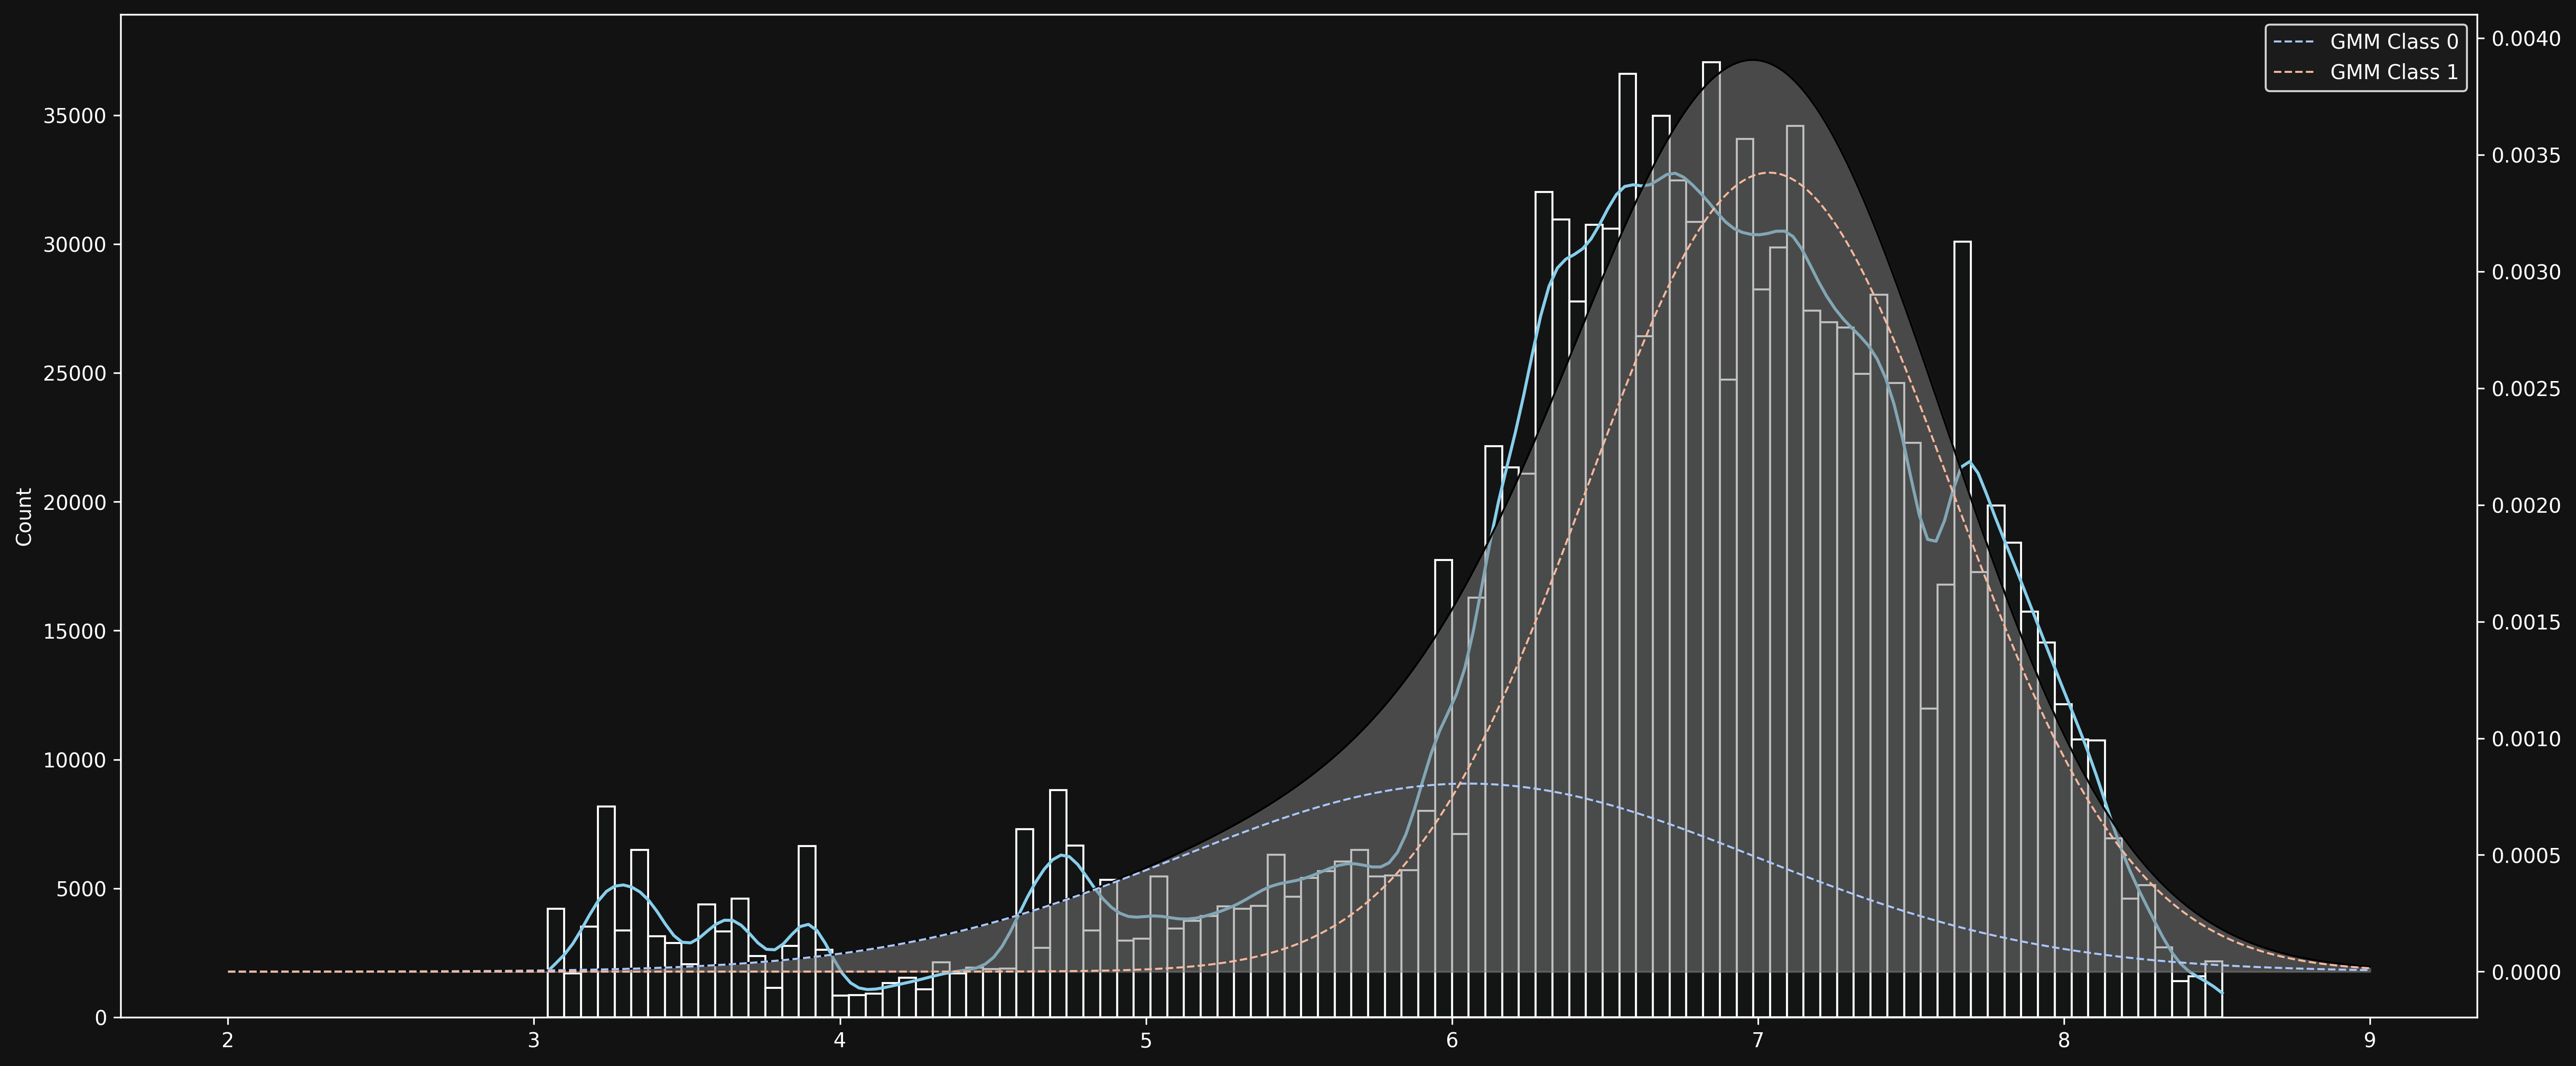

In [64]:
from sklearn.metrics import silhouette_samples
GMM_COMPONENTS = 2

gmm_columns = []

_y = y.reshape(-1, 1).copy()
log_y = np.log1p(_y)
rest = log_y[log_y <= 4]
_y = log_y[log_y > 4]
gmm = GaussianMixture(
    n_components=GMM_COMPONENTS, 
    random_state=42, 
    # init_params='random_from_data',
    init_params='kmeans', 
    tol=1e-4,
    max_iter=1000)
for col in data.columns:
    if 'gmm' in col:
        del data[col]
gmm.fit(_y.reshape(-1, 1))

data['gmm_class'] = -99
data['gmm_class'].iloc[:len(log_y)] = gmm.predict(log_y.reshape(-1, 1))
data.gmm_class.loc[np.pad(log_y.reshape(-1), (0, len(data)-len(y)), constant_values=np.nan) <= 4] = GMM_COMPONENTS + 1
data.gmm_class = data.gmm_class.astype(int)
gmm_columns.append('gmm_class')

# data[[f'gmm_proba_{i}' for i in range(GMM_COMPONENTS)]] = np.pad(gmm.predict_proba(_y.reshape(-1, 1)), ((0,len(data)-len(_y)), (0, 0)))
# gmm_columns += [f'gmm_proba_{i}' for i in range(GMM_COMPONENTS)]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

pallete = sns.color_palette('coolwarm', GMM_COMPONENTS)
sns.histplot(np.hstack([_y, rest]), bins=100, color='skyblue',  label='Premium Amount', kde=True, alpha=0.01)
# # draw differnt gmm class pdf plot
# for i in range(GMM_COMPONENTS):
#     ax.hist(_y[data.iloc[:len(_y)][f'gmm_proba_{i}'] > 0.1], bins=100, color=pallete[i], edgecolor='white', label=f'GMM Class {i}', alpha=0.5)
# plt.legend()

x = np.linspace(2, 9, 1000)
pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
pdf = pdf / pdf.sum()
pdf_individual = gmm.predict_proba(x.reshape(-1, 1))
pdf_individual = pdf_individual * pdf.sum() * pdf[:, np.newaxis]
ax2 = ax.twinx()
ax2.fill_between(x, pdf, color='gray', alpha=0.5)
ax2.plot(x, pdf, color='black', linewidth=1)
for i in range(GMM_COMPONENTS):
    ax2.plot(x, pdf_individual[:, i], '--', color=pallete[i], linewidth=1, label=f'GMM Class {i}')
plt.legend()
del _y

In [27]:
data[gmm_columns].iloc[:len(y)]

,gmm_class
id,
0,1
1,1
2,0
3,0
4,1
...,...
1199995,1
1199996,0
1199997,0


# Data Preprocessing

In [72]:
# policy_start_date 피처 전처리
data['policy_start_date'] = pd.to_datetime(data['policy_start_date'])
data['policy_start_date'] = (data['policy_start_date'] - pd.to_datetime('1970-01-01')).dt.days

In [73]:
# --- 2. 결측치 처리 ---

# number_of_dependents, insurance_duration, previous_claims is categorical
data['number_of_dependents'] = data['number_of_dependents'].apply(lambda x: str(x))
data['insurance_duration'] = data['insurance_duration'].apply(lambda x: str(x))
data['previous_claims'] = data['previous_claims'].apply(lambda x: str(x))


# age to binned, vehicle_age to binned
data['age'] = pd.qcut(data['age'], q=8, duplicates='raise')
data['vehicle_age'] = pd.qcut(data['vehicle_age'], q=8, duplicates='raise')


categorical_columns = data.select_dtypes(include=['object', 'category']).columns
ordinal_categories = pd.Index(['age', 'vehicle_age', 'number_of_dependents', 'insurance_duration', 'previous_claims'])
categorical_columns = categorical_columns.drop(ordinal_categories)

# 범주형 변수의 결측치를 'unknown'으로 대체
for col in categorical_columns:
    data[col].fillna('unknown', inplace=True)


# 수치형 변수의 결측치를 최대값 + 10%로 대체
float_columns = data.select_dtypes(include=['float64']).columns.drop(gmm_columns, errors='ignore')
for col in float_columns:
    data[col].fillna(data[col].max() * 1.1, inplace=True)
    
int_columns = data.select_dtypes(include=['int64']).columns.drop(gmm_columns, errors='ignore')
for col in int_columns:
    data[col].fillna(data[col].max()+int(data[col].std()), inplace=True)
numerical_columns = float_columns.append(int_columns)

# --- 3. 범주형 변수 인코딩 및 수치형 스케일링 ---
# 범주형 변수 인코딩
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
    
    
# 순서 범주형 변수 인코딩
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)
data[ordinal_categories] = ordinal_encoder.fit_transform(data[ordinal_categories])
categorical_columns = categorical_columns.append(ordinal_categories)
# 수치형 변수 스케일링
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# y 스케일링

y_scaler = StandardScaler()
y_scaler.fit(np.log1p(y).reshape(-1,1))
# y_scaler_torch = TorchStandardScaler()
# y_scaler_torch.fit(torch.tensor(torch.log1p(torch.tensor(y, dtype=torch.float32).to(device)).squeeze(-1)))
y = y_scaler.transform(np.log1p(y).reshape(-1,1)).reshape(-1)

data[target_column] = np.pad(y, (0, data.shape[0]-len(y)), 'constant', constant_values=np.nan)


X = data[:len(y)].drop(columns=[target_column]+ gmm_columns).copy()
c = data[gmm_columns].iloc[:len(y)].copy()
if GMM_COMPONENTS == 1:
    c = c.astype(bool)
X_test = data[data[target_column].isna()].drop(columns=[target_column]+gmm_columns).copy()

y_val_origin = data[target_column].values[:len(y)]

# Functions

In [74]:
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error

def inverse_y(y):
    return np.expm1(y_scaler.inverse_transform(y.reshape(-1,1)).reshape(-1))

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    
    
    y_pred = inverse_y(y_pred)
    y_val = inverse_y(y_val)
    
    rmsle = mean_squared_log_error(y_val, y_pred) ** (1/2)
    return r2, mse, rmsle

def evaluate_model_no_inverse(model, X_val, y_val):
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    # y_pred = inverse_y(y_pred)
    # y_val = inverse_y(y_val)
    rmsle = mean_squared_log_error(y_val, y_pred) ** (1/2)
    return r2, mse, rmsle

In [75]:
# for lgboost
from typing import Tuple

# for lgboost
def rmlse(preds, dtrain: np.ndarray):
    dtrain = np.log1p(dtrain)
    preds = np.log1p(preds)
    return 'RMLSE', np.sqrt(mean_squared_error(dtrain, preds)), False

def rmlse_with_inverse(preds, dtrain: np.ndarray):
    dtrain = inverse_y(dtrain)
    preds = inverse_y(preds)
    
    dtrain = np.log1p(dtrain)
    preds = np.log1p(preds)
    return 'RMLSE', np.sqrt(mean_squared_error(dtrain, preds)), False

# for catboost
class RMLSEMetricInv(object):
    @staticmethod
    def is_max_optimal():
        # RMLSE는 값이 작을수록 좋으므로 False 반환
        return False

    def evaluate(self, approxes, target, weight=None):
        """
        RMLSE 계산 함수.
        
        Args:
            approxes: 예측값의 리스트 (CatBoost에서 제공)
            target: 실제 타겟값
            weight: 가중치 (없을 수 있음, None 처리 필요)
        
        Returns:
            (error, weights sum)
        """
        # 예측값 가져오기
        preds = np.array(approxes[0])  # approxes는 리스트로 제공됨
        target = np.array(target)
        
        # invesre transform
        preds = inverse_y(preds)
        target = inverse_y(target)

        # 음수값 방지
        if np.any(target < 0) or np.any(preds < 0):
            raise ValueError("RMLSE cannot be calculated for negative values.")

        # 로그 변환
        preds = np.log1p(preds)
        target = np.log1p(target)

        error_sum = 0.0
        # 가중치 처리

        if weight is None:
            weight = np.ones(target.shape[0])
        
        error_sum = np.sum((weight * (preds - target) ** 2) * weight) / target.shape[0]
        weight_sum = np.sum(weight)

        return error_sum, weight_sum

    def get_final_error(self, error, weight):
        """
        최종 에러 값 반환.
        
        Args:
            error: RMLSE 값
            weight: 가중치 합계
        
        Returns:
            최종 RMLSE 값
        """
        return np.sqrt(error / (weight + 1e-38))  # RMLSE 자체를 최종 결과로 반환
    
class RMLSEMetric(object):
    @staticmethod
    def is_max_optimal():
        # RMLSE는 값이 작을수록 좋으므로 False 반환
        return False

    def evaluate(self, approxes, target, weight=None):
        """
        RMLSE 계산 함수.
        
        Args:
            approxes: 예측값의 리스트 (CatBoost에서 제공)
            target: 실제 타겟값
            weight: 가중치 (없을 수 있음, None 처리 필요)
        
        Returns:
            (error, weights sum)
        """
        if weight is None:
            weight = np.ones(target.shape[0])
        # 예측값 가져오기
        preds = np.array(approxes[0])  # approxes는 리스트로 제공됨
        target = np.array(target)


        # 음수값 방지
        if np.any(target < 0) or np.any(preds < 0):
            return 1e6, np.sum(weight)

        # 로그 변환
        preds = np.log1p(preds)
        target = np.log1p(target)

        error_sum = 0.0
        # 가중치 처리

        
        error_sum = np.sum((weight * (preds - target) ** 2) * weight) / target.shape[0]
        weight_sum = np.sum(weight)

        return error_sum, weight_sum

    def get_final_error(self, error, weight):
        """
        최종 에러 값 반환.
        
        Args:
            error: RMLSE 값
            weight: 가중치 합계
        
        Returns:
            최종 RMLSE 값
        """
        return np.sqrt(error / (weight + 1e-38))  # RMLSE 자체를 최종 결과로 반환

# for xgboost
def rmlse_objective_with_inverse(labels, preds):
    y = inverse_y(labels)
    yhat = inverse_y(preds)
    eps = 1e-6 # + 1
    y = np.maximum(labels, eps)  # Ensure preds >= 0
    yhat = np.maximum(preds, eps)  # Ensure labels >= 0
    log1p_y = np.log1p(y)
    log1p_yhat = np.log1p(yhat)

    diff = (log1p_yhat - log1p_y)

    grad = diff / (yhat + 1.0)
    hess = (1 - diff) / np.power(yhat + 1.0, 2)

    return grad, hess

def rmlse_evaluation_with_inverse(labels, preds):
    y = inverse_y(labels)
    yhat = inverse_y(preds)
    n = y.shape[0]
    eps = 1e-6
    y = np.maximum(labels, eps)  # Ensure preds >= 0
    yhat = np.maximum(preds, eps)  # Ensure labels >= 0
    log1p_y = np.log1p(y)
    log1p_yhat = np.log1p(yhat)
    rmlse = np.sqrt(np.sum((log1p_yhat - log1p_y)**2)) / n
    return rmlse


def rmlse_objective(labels, preds):
    y = labels
    yhat = preds
    eps = 1e-6 + 1
    y = np.maximum(labels, eps)  # Ensure preds >= 0
    yhat = np.maximum(preds, eps)  # Ensure labels >= 0
    log1p_y = np.log1p(y)
    log1p_yhat = np.log1p(yhat)

    diff = (log1p_yhat - log1p_y)

    grad = diff / (yhat + 1.0)
    hess = (1 - diff) / np.power(yhat + 1.0, 2)

    return grad, hess

def rmlse_evaluation(labels, preds):
    y = labels
    yhat = preds
    n = y.shape[0]
    eps = 1e-6 + 1
    y = np.maximum(labels, eps)  # Ensure preds >= 0
    yhat = np.maximum(preds, eps)  # Ensure labels >= 0
    log1p_y = np.log1p(y)
    log1p_yhat = np.log1p(yhat)
    rmlse = np.sqrt(np.sum((log1p_yhat - log1p_y)**2)) / n
    return rmlse

def gradient(labels: np.ndarray, preds: np.ndarray) -> np.ndarray:
    '''Compute the gradient squared log error.'''
    return (np.log1p(preds) - np.log1p(labels)) / (preds + 1)

def hessian(labels: np.ndarray, preds: np.ndarray) -> np.ndarray:
    '''Compute the hessian for squared log error.'''

    return ((-np.log1p(preds) + np.log1p(labels) + 1) /
            np.power(preds + 1, 2))

def squared_log(labels: np.ndarray,
                preds: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    labels[labels < -1] = -1 + 1e-6
    grad = gradient(labels, preds)
    hess = hessian(labels, preds)
    return grad, hess

# Solving Classifing Problem

## Devide Dataset

In [112]:
X

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,previous_claims,vehicle_age,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,non_log
id,,,,,,,,,,,,,,,,,,,,
0,0.0,0,-0.685909,1,1.0,0,1,-0.359399,2,2,2.0,6.0,-1.459636,4.0,1.300820,2,0,3,2,0.242583
1,3.0,0,-0.149665,0,3.0,2,3,-0.823814,0,1,1.0,4.0,0.347957,1.0,0.928832,0,1,1,2,-0.622273
2,0.0,1,-0.300306,0,3.0,1,1,1.264546,1,2,1.0,5.0,1.694669,2.0,1.139753,1,1,3,2,-0.011678
3,0.0,1,2.581937,1,2.0,0,3,-1.129828,0,0,1.0,0.0,-1.487704,0.0,1.630624,2,1,0,0,0.790613
4,0.0,1,0.048009,2,1.0,0,1,-0.506253,0,2,0.0,3.0,-0.190953,3.0,-0.141113,2,1,3,2,0.920399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,3.0,0,-0.257811,1,0.0,2,2,-0.942532,2,2,10.0,1.0,-1.459636,2.0,0.852133,2,0,0,0,0.523744
1199996,6.0,1,-0.047816,0,5.0,2,1,-1.093797,0,1,10.0,3.0,-0.196567,3.0,0.401530,2,0,3,0,0.469496
1199997,0.0,1,0.351300,0,0.0,2,3,-0.879662,1,0,0.0,7.0,1.694669,5.0,-0.505431,1,0,1,1,-2.836626


In [91]:
X_train, X_val, c_train, c_val = train_test_split(X.values, c, test_size=0.2, random_state=42)

In [92]:
X.columns

Index(['age', 'gender', 'annual_income', 'marital_status',
       'number_of_dependents', 'education_level', 'occupation', 'health_score',
       'location', 'policy_type', 'previous_claims', 'vehicle_age',
       'credit_score', 'insurance_duration', 'policy_start_date',
       'customer_feedback', 'smoking_status', 'exercise_frequency',
       'property_type', 'non_log'],
      dtype='object')

In [160]:
c.value_counts().min()/c.value_counts().max()

0.05603125852525235

In [102]:
# use XGBoost for classiying
# DMatrix 생성 (XGBoost 전용 데이터 포맷)
dtrain = xgb.DMatrix(X_train, label=c_train)
dval = xgb.DMatrix(X_val, label=c_val)

# XGBoost 모델 파라미터 설정
params = {
    "objective": "multi:softmax" if GMM_COMPONENTS > 1 else "binary:logistic",
    "num_class": GMM_COMPONENTS + 1 if GMM_COMPONENTS > 1 else 1,
    "max_depth": 16,               # 트리 깊이
    "eta": 0.3,                   # 학습률
    "eval_metric": "mlogloss" if GMM_COMPONENTS > 1 else "auc",
    "seed": 42,
    "nthread": -1,
    'gpu_id': 0,
    'tree_method': 'gpu_hist',
}

# 훈련
evals = [(dtrain, 'train'), (dval, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=False
)

# 검증 데이터 예측
xgb_preds = xgb_model.predict(dval)
if GMM_COMPONENTS > 1:
    accuracy = accuracy_score(c_val, xgb_preds)
else:
    accuracy = accuracy_score(c_val, xgb_preds > 0.5)
print(f"XGBoost Validation Accuracy: {accuracy:.4f}")


XGBoost Validation Accuracy: 0.9463


In [153]:
c_train.value_counts(), 50869/909131

(gmm_class
 False        909150
 True          50850
 Name: count, dtype: int64,
 0.05595343245362879)

In [167]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score

weight = 75
# LightGBM 모델 생성
lgb_model = LGBMClassifier(
    objective="multiclass" if GMM_COMPONENTS > 1 else 'binary',    # 다중 클래스 분류
    num_class=GMM_COMPONENTS + 1 if GMM_COMPONENTS > 1 else 1,      # 클래스 수
    max_depth=16,               # 트리 깊이
    learning_rate=0.1,         # 학습률
    n_estimators=500,          # 부스팅 반복 횟수
    num_leaves=31,             # 리프 노드 수
    class_weight={True: weight, False: 100-weight},
    random_state=42,
    verbose=-1
)

# 모델 훈련
lgb_model.fit(X_train, c_train, eval_set=[(X_val, c_val)], eval_metric='multi_logloss' if GMM_COMPONENTS > 1 else 'precision')

# 검증 데이터 예측
lgb_preds = lgb_model.predict(X_val)
accuracy = auc(c_val, lgb_preds)
print(f"""LightGBM Validation 
Accuracy: {accuracy_score(c_val, lgb_preds):.4f}
AUC: {auc(c_val, lgb_preds):.4f}
f1 : {f1_score(c_val, lgb_preds):.4f}
precision : {precision_score(c_val, lgb_preds):.4f}
""")


LightGBM Validation 
Accuracy: 0.9471
AUC: 331.5000
f1 : 0.0503
precision : 0.5915



LightGBM Validation 
Accuracy: 0.9143
AUC: 2776.5000
f1 : 0.1936
precision : 0.1943

In [155]:
pd.Series(lgb_preds).value_counts(), c_val.value_counts()

(False    234503
 True       5497
 Name: count, dtype: int64,
 gmm_class
 False        227199
 True          12801
 Name: count, dtype: int64)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 모델 생성
rf_model = RandomForestClassifier(
    n_estimators=100,  # 트리 개수
    max_depth=10,      # 트리 깊이
    random_state=42,
    n_jobs=-1          # 병렬 처리
)

# 모델 훈련
rf_model.fit(X_train, c_train)

# 검증 데이터 예측
rf_preds = rf_model.predict(X_val)
accuracy = accuracy_score(c_val, rf_preds)
print(f"Random Forest Validation Accuracy: {accuracy:.4f}")


Random Forest Validation Accuracy: 0.4678


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# 모델 생성
cat_model = CatBoostClassifier(
    iterations=1000,          # 최대 반복 횟수
    learning_rate=0.1,        # 학습률
    depth=10,                 # 트리 깊이
    random_seed=42,
    eval_metric='MultiClass',
    verbose=100
)

# 모델 훈련
cat_model.fit(X_train, c_train, eval_set=(X_val, c_val), early_stopping_rounds=50)

# 검증 데이터 예측
cb_preds = cat_model.predict(X_val).reshape(-1)
accuracy = auc(c_val, cb_preds)
print(f"CatBoost Validation Accuracy: {accuracy:.4f}")


0:	learn: 1.5430836	test: 1.5432522	best: 1.5432522 (0)	total: 951ms	remaining: 15m 50s
100:	learn: 1.2278444	test: 1.2441636	best: 1.2441636 (100)	total: 1m 37s	remaining: 14m 23s
200:	learn: 1.2070960	test: 1.2410181	best: 1.2409481 (192)	total: 3m 15s	remaining: 12m 55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.240656663
bestIteration = 217

Shrink model to first 218 iterations.
CatBoost Validation Accuracy: 0.4837


In [22]:
xgb_preds.shape, lgb_preds.shape, rf_preds.shape, cb_preds.shape

((240000,), (240000,), (240000,), (240000,))

In [31]:
vote_preds = np.vstack([xgb_preds.astype(int), lgb_preds.astype(int), rf_preds.astype(int), cb_preds.astype(int)]).T
vote_preds = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=vote_preds)
accuracy = accuracy_score(c_val, vote_preds)
vote_preds, accuracy

(array([1, 1, 1, ..., 1, 1, 1], dtype=int64), 0.4860333333333333)

In [9]:
pd.Series(c).value_counts()

gmm_class
4    552536
0    296263
2    156403
1    138874
3     55924
Name: count, dtype: int64

In [ ]:
from sklearn.svm import SVC
svc = SVC(C=0.001, random_state=42)
svc.fit(X_train, c_train)
svc_preds = svc.predict(X_val)
accuracy = accuracy_score(c_val, svc_preds)
print(f"SVC Validation Accuracy: {accuracy:.4f}")

In [ ]:
accuracy = accuracy_score(c_val, svc_preds)
print(f"SVC Validation Accuracy: {accuracy:.4f}")

In [ ]:
# first, continue with LightGBM Classifier

In [169]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
oof = np.zeros(X.shape[0])
test_class = np.zeros(X_test.shape[0])
test_proba = np.zeros((X_test.shape[0], GMM_COMPONENTS+1))


for fold, (train_idx, val_idx) in enumerate(kf.split(X, c)):
    X_train, _X_val = X.values[train_idx], X.values[val_idx]
    c_train, _c_val = c.iloc[train_idx], c.iloc[val_idx]
    
    lgb_model = LGBMClassifier(
        objective="multiclass" if GMM_COMPONENTS > 1 else 'binary',    # 다중 클래스 분류
        num_class=GMM_COMPONENTS + 1 if GMM_COMPONENTS > 1 else 1,      # 클래스 수
        max_depth=16,               # 트리 깊이
        learning_rate=0.1,         # 학습률
        n_estimators=500,          # 부스팅 반복 횟수
        num_leaves=31,             # 리프 노드 수
        class_weight={True: weight, False: 100-weight},
        random_state=42,
        verbose=-1
    )

    # 모델 훈련
    lgb_model.fit(X_train, c_train, eval_set=[(_X_val, _c_val)], eval_metric='multi_logloss' if GMM_COMPONENTS > 1 else 'precision')
    lgb_preds = lgb_model.predict(_X_val)
    print(f"""LightGBM Validation Fold {fold}
Accuracy: {accuracy_score(_c_val, lgb_preds):.4f}
AUC: {auc(_c_val, lgb_preds):.4f}
f1 : {f1_score(_c_val, lgb_preds):.4f}
precision : {precision_score(_c_val, lgb_preds):.4f}
""")
    oof[val_idx] = lgb_model.predict(_X_val)
    test_class += lgb_model.predict(X_test.values) / kf.n_splits

    test_proba += lgb_model.predict_proba(X_test.values) / kf.n_splits


LightGBM Validation Fold 0
Accuracy: 0.9456
AUC: 179.0000
f1 : 0.0243
precision : 0.2767

LightGBM Validation Fold 1
Accuracy: 0.9464
AUC: 149.5000
f1 : 0.0215
precision : 0.3006

LightGBM Validation Fold 2
Accuracy: 0.9459
AUC: 189.0000
f1 : 0.0263
precision : 0.2846

LightGBM Validation Fold 3
Accuracy: 0.9464
AUC: 194.0000
f1 : 0.0271
precision : 0.3135

LightGBM Validation Fold 4
Accuracy: 0.9459
AUC: 151.5000
f1 : 0.0217
precision : 0.3214



In [162]:
pd.Series(oof).round().value_counts().min() / pd.Series(oof).round().value_counts().max()

0.013296989747967706

In [148]:
5318/794682

0.0066919849700886646

In [150]:
9771/790229

0.012364770212179

In [ ]:
oof.value

In [161]:
(oof == c.values.reshape(-1)).mean()

0.9401991666666667

In [170]:
test_proba.argmax(1)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [181]:
data['gmm_class_lgb'] = np.hstack([oof, test_proba.argmax(1)])
X = data[:len(y)].drop(columns=[target_column, 'gmm_class']).copy()
X_test = data[data[target_column].isna()].drop(columns=[target_column, 'gmm_class'])

y_val_origin = data[target_column].values[:len(y)]

# Solving Regression on each class

## Devide Dataset

In [184]:
X = X.drop(columns=gmm_columns+['gmm_class_lgb'], errors='ignore')
X_test = X_test.drop(columns=gmm_columns+['gmm_class_lgb'], errors='ignore')

In [185]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X.values, y, test_size=0.2, random_state=42)

## Modeling

In [188]:
# TODO: LightGBM Regressor

lgbm = LGBMRegressor(
    # **{
    #     'n_estimators': 904,
    #     'learning_rate': 0.22397849703318146,
    #     'max_depth': 6,
    #     'reg_lambda': 1.0772060124044087,
    #     'subsample': 0.7276099887947944,
    #     'subsample_freq': 1,
    #     'min_child_samples': 12
    # },
    
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=20,
    learning_rate=0.1,
    
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)

lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mse')
evaluate_model(lgbm, X_val, y_val)

(0.11377899742557596, 0.8871727423499303, 1.0321551807977076)

In [ ]:
(0.11362345062333701, 0.8873284561986262, 1.0322457571850852)

In [35]:
c_val.iloc[:, 0:1]

,gmm_proba_0
id,
372605,0.000047
551204,0.928921
240320,0.031310
1047361,0.047700
555362,0.687555
...,...
458271,0.911099
1124744,0.000074
720454,0.368342


In [37]:
lgbm = LGBMRegressor(
    # **{
    #     'n_estimators': 904,
    #     'learning_rate': 0.22397849703318146,
    #     'max_depth': 6,
    #     'reg_lambda': 1.0772060124044087,
    #     'subsample': 0.7276099887947944,
    #     'subsample_freq': 1,
    #     'min_child_samples': 12
    # },
    
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=20,
    learning_rate=0.1,
    
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)
lgbm.fit(X_train, c_train.iloc[:, 0], eval_set=[(X_val, c_val.iloc[:, 0])], eval_metric=RMLSEMetric())

LGBMRegressor(device_type='gpu', gpu_id=0, max_depth=20, min_child_samples=7,
              min_child_weight=0.003, n_estimators=500, n_jobs=-1,
              random_state=42, verbosity=-1)

In [ ]:
mean_squared_error(c_val.iloc[:, 0].values, lgbm.predict(X_val))

In [ ]:
evaluate_model(lgbm, X_val, y_val) # non_log_with_simpler_date

(0.08819323832124804, 0.9127859787816465, 1.0469486517414626)

In [30]:
evaluate_model(lgbm, X_val, y_val)

(0.10041606821976368, 0.9005500224131534, 1.0399077683210711)

In [87]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models= []
oof_preds = np.zeros(X.shape[0])
for train_idx, val_idx in kf.split(X):
    X_train, _X_val = X.values[train_idx], X.values[val_idx]
    y_train, _y_val = y[train_idx], y[val_idx]
    lgbm = LGBMRegressor(
    # **{
    #     'n_estimators': 904,
    #     'learning_rate': 0.22397849703318146,
    #     'max_depth': 6,
    #     'reg_lambda': 1.0772060124044087,
    #     'subsample': 0.7276099887947944,
    #     'subsample_freq': 1,
    #     'min_child_samples': 12
    # },
    
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=20,
    learning_rate=0.1,
    
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)
    lgbm.fit(X_train, y_train, eval_set=[(_X_val, _y_val)])
    models.append(lgbm)
    pred = lgbm.predict(_X_val)
    oof_preds[val_idx] = pred
    print(evaluate_model(lgbm, _X_val, _y_val))
del _X_val, _y_val

(0.11344812006720373, 0.8875039750475938, 1.0323478443137144)
(0.1124926719661914, 0.8865096330434379, 1.0317693711270786)
(0.10927510966179543, 0.8895044432828086, 1.033510665376858)
(0.11527349123908814, 0.8843836589412031, 1.0305314648771844)
(0.1133304219818222, 0.8882391868995831, 1.032775356340944)


In [77]:
test_data
ps = []

for model in models:
    ps.append(model.predict(test_data))


array([2869., 1483.,  567., ...,  371.,  596., 2480.])

<Axes: >

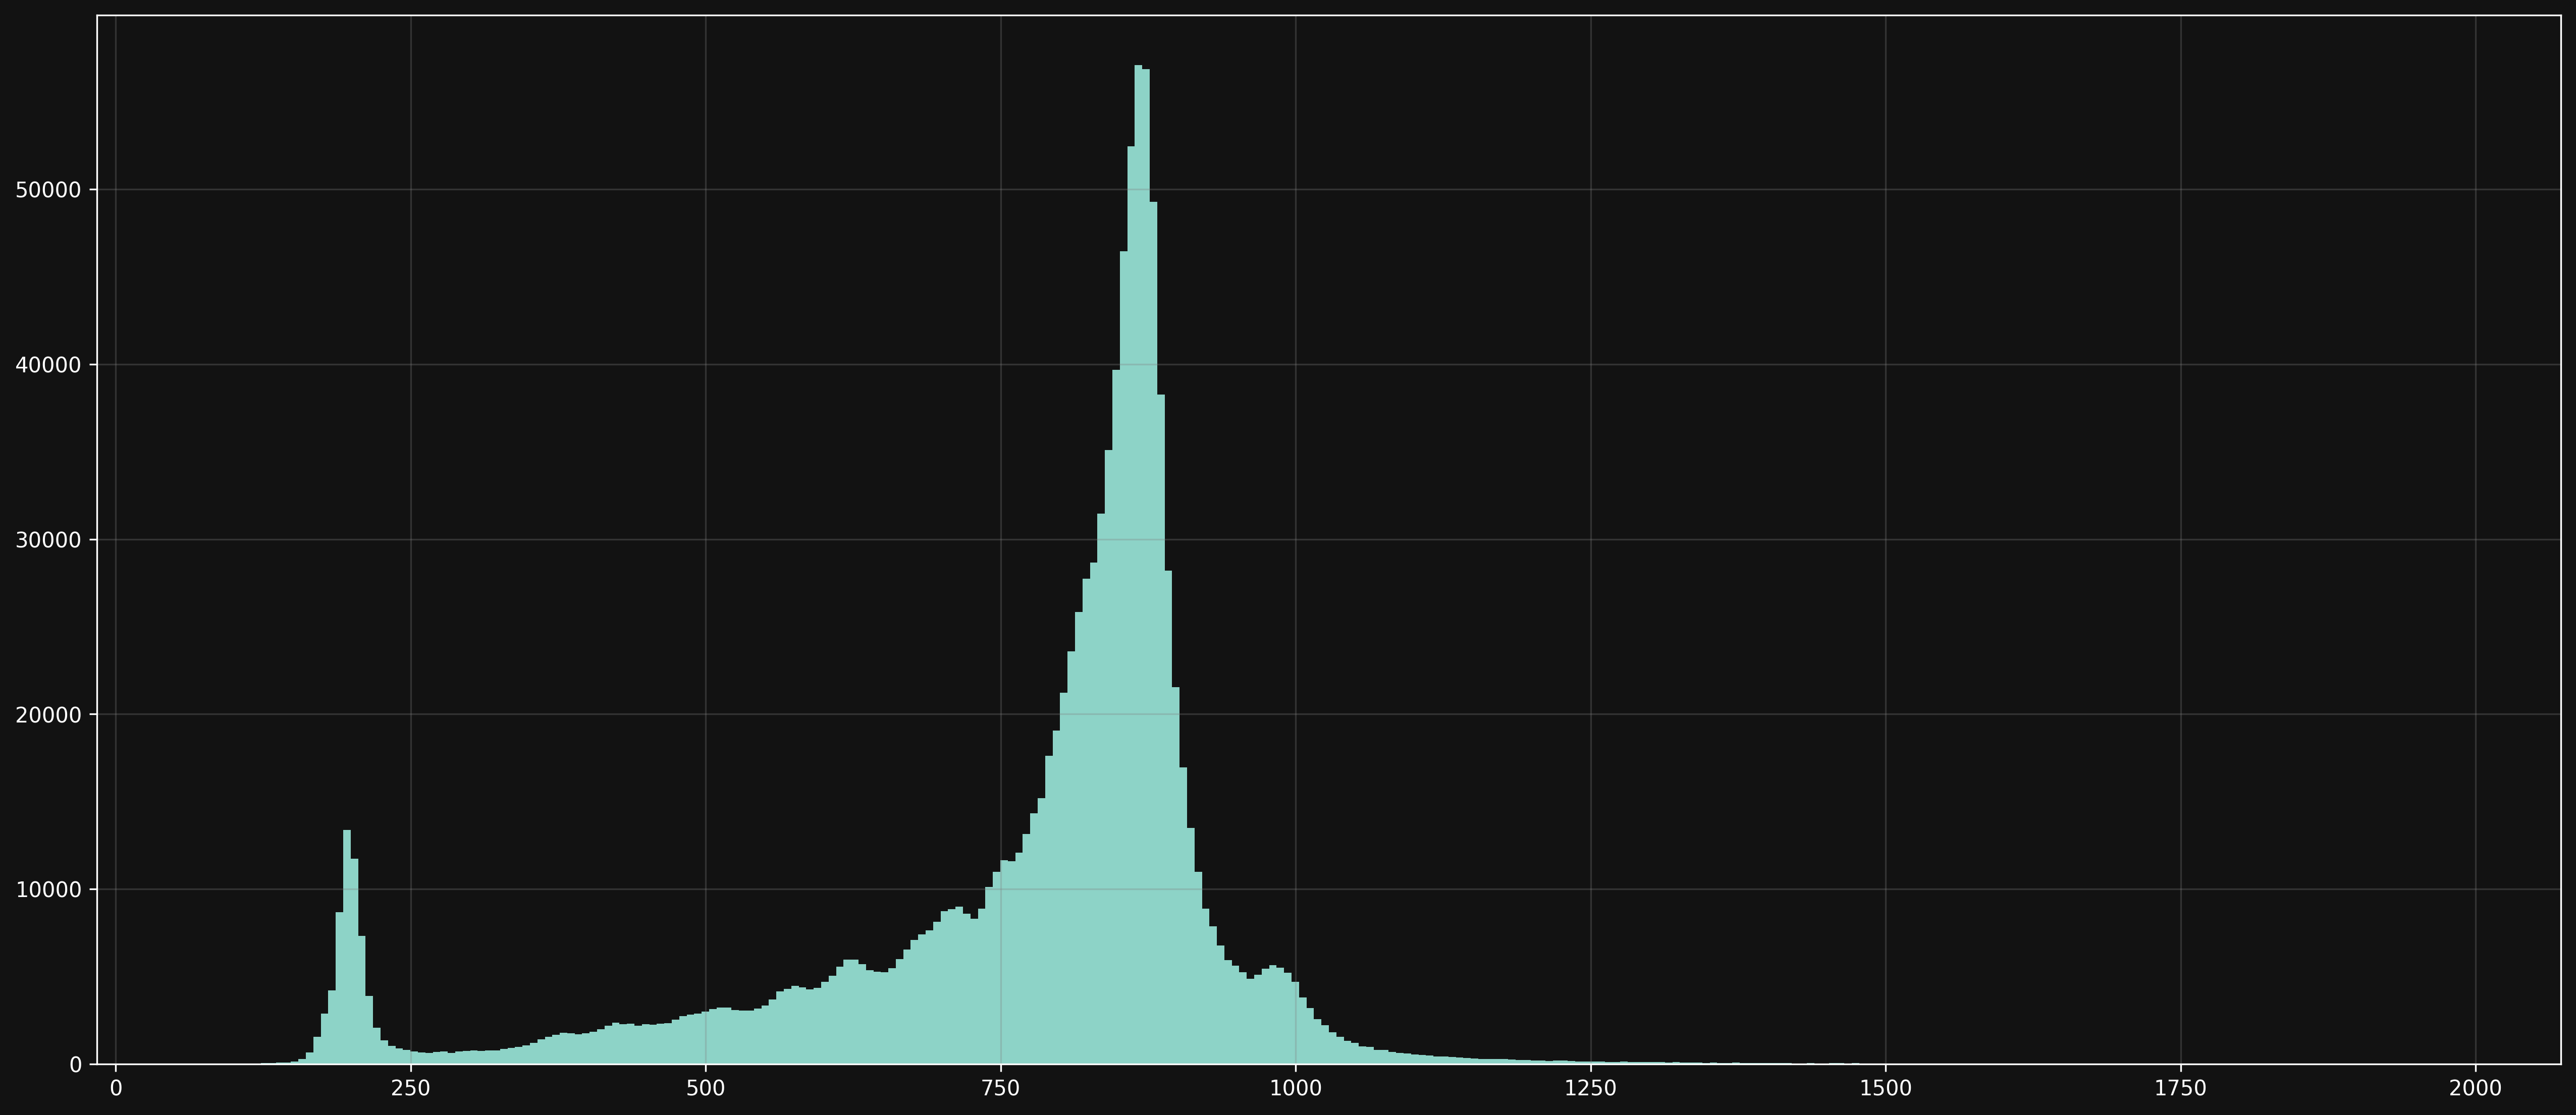

In [97]:
pd.Series(inverse_y(oof_preds)).hist(bins=300)

In [101]:
pd.Series(inverse_y(X.non_log.values)).max()

21303647.8780094

In [109]:
mean_squared_log_error(np.array([1.2,2,3]), np.array([1,2,3]))

0.0030280101247775796

<Axes: >

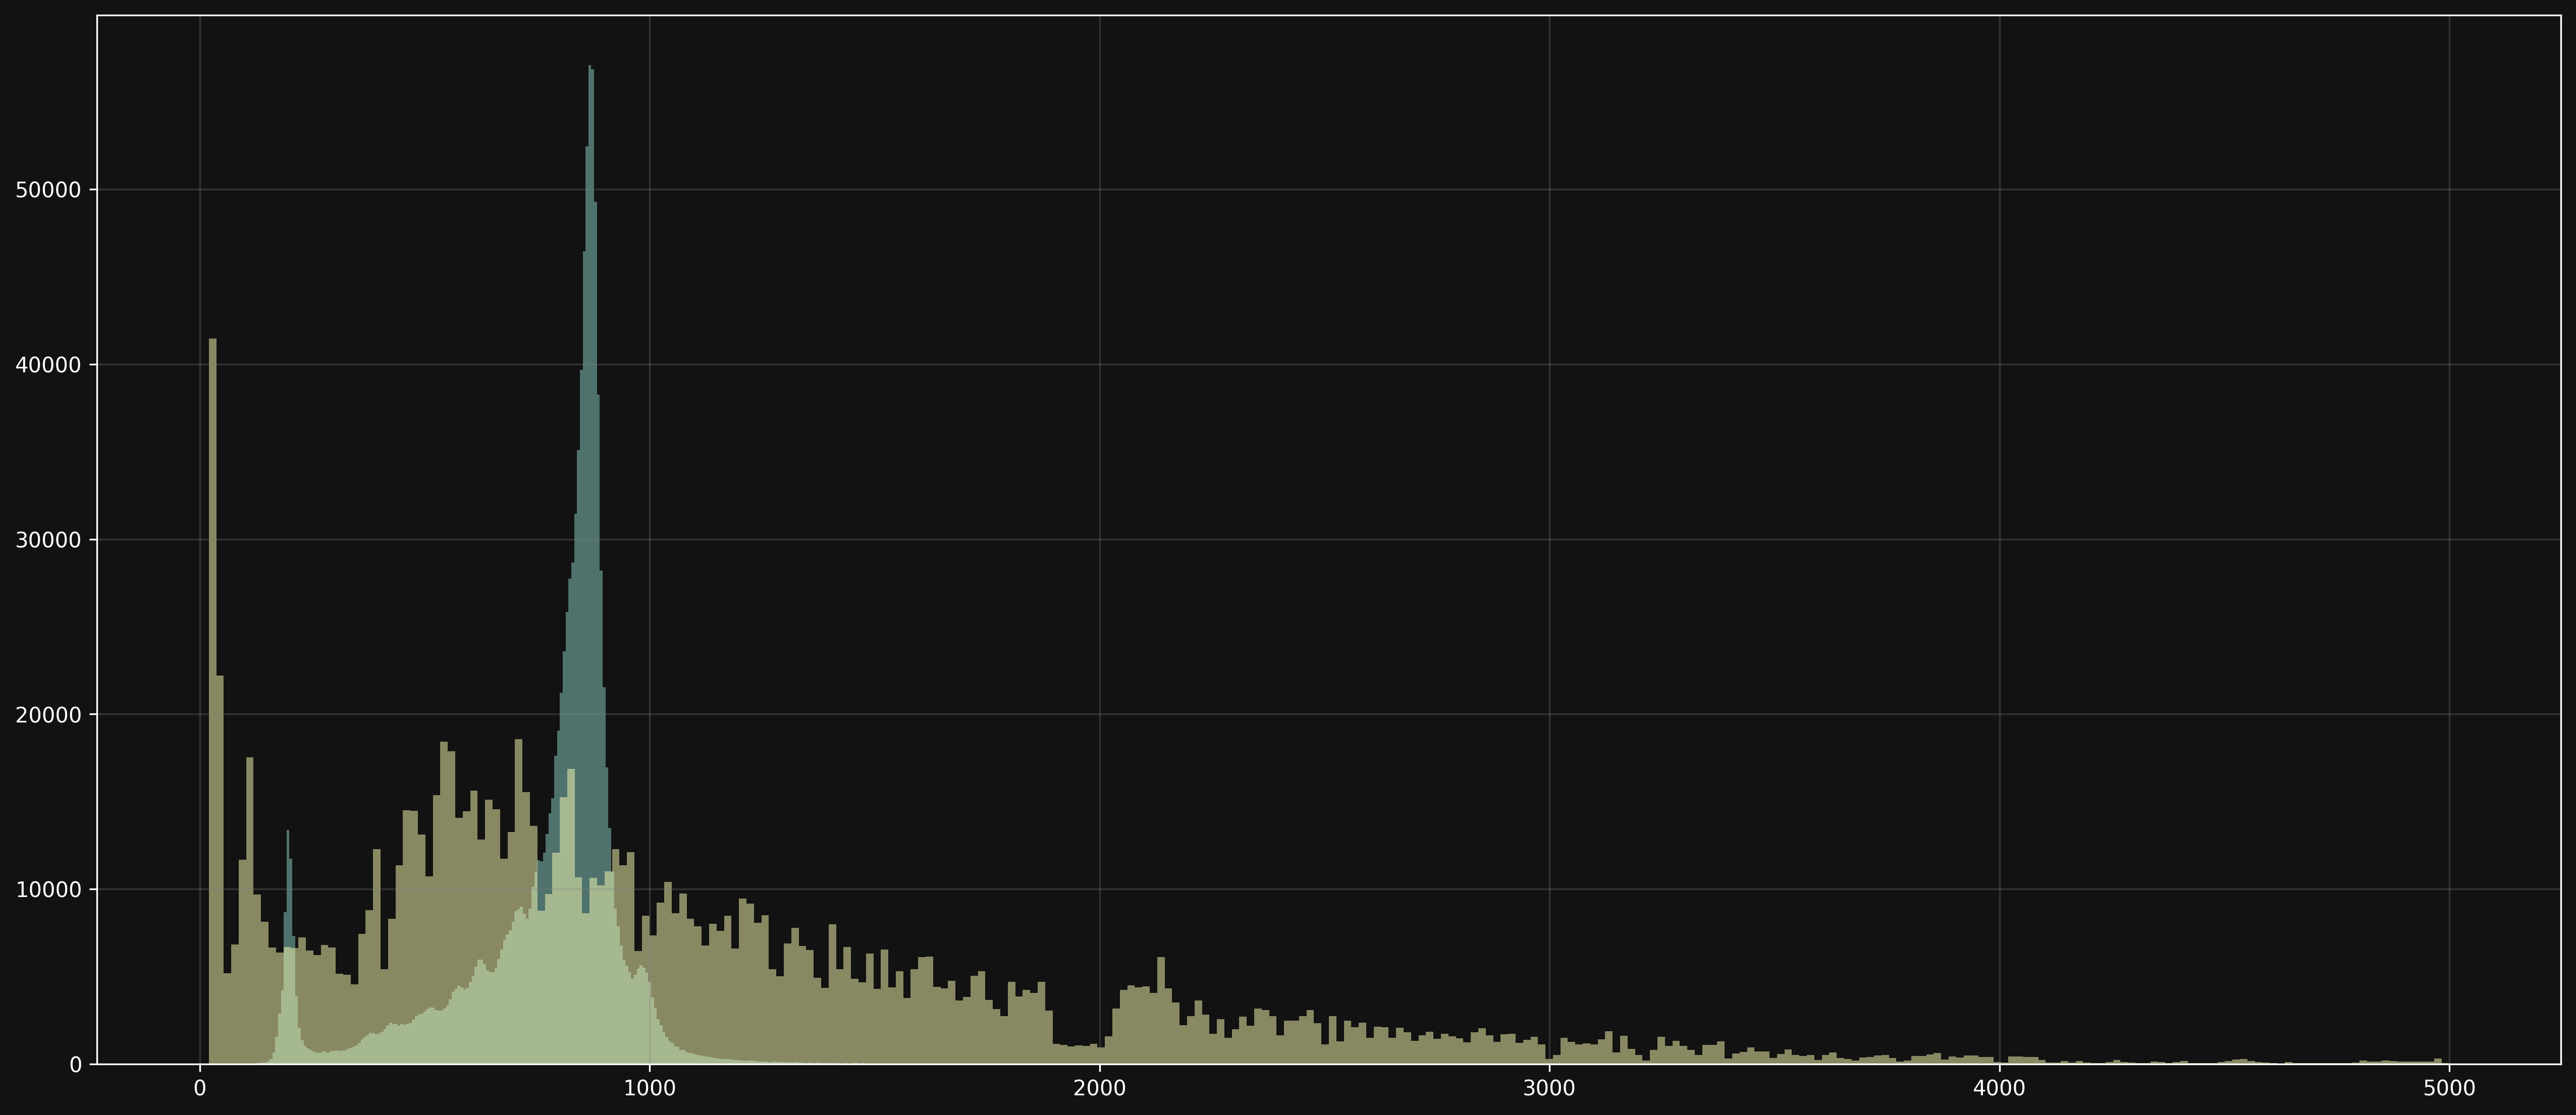

In [102]:
pd.Series(inverse_y(oof_preds)).hist(bins=300, alpha=0.5)
# pd.Series(inverse_y(X.non_log.values)).hist(bins=300, alpha=0.5)
pd.Series(inverse_y(y)).hist(bins=300, alpha=0.5)

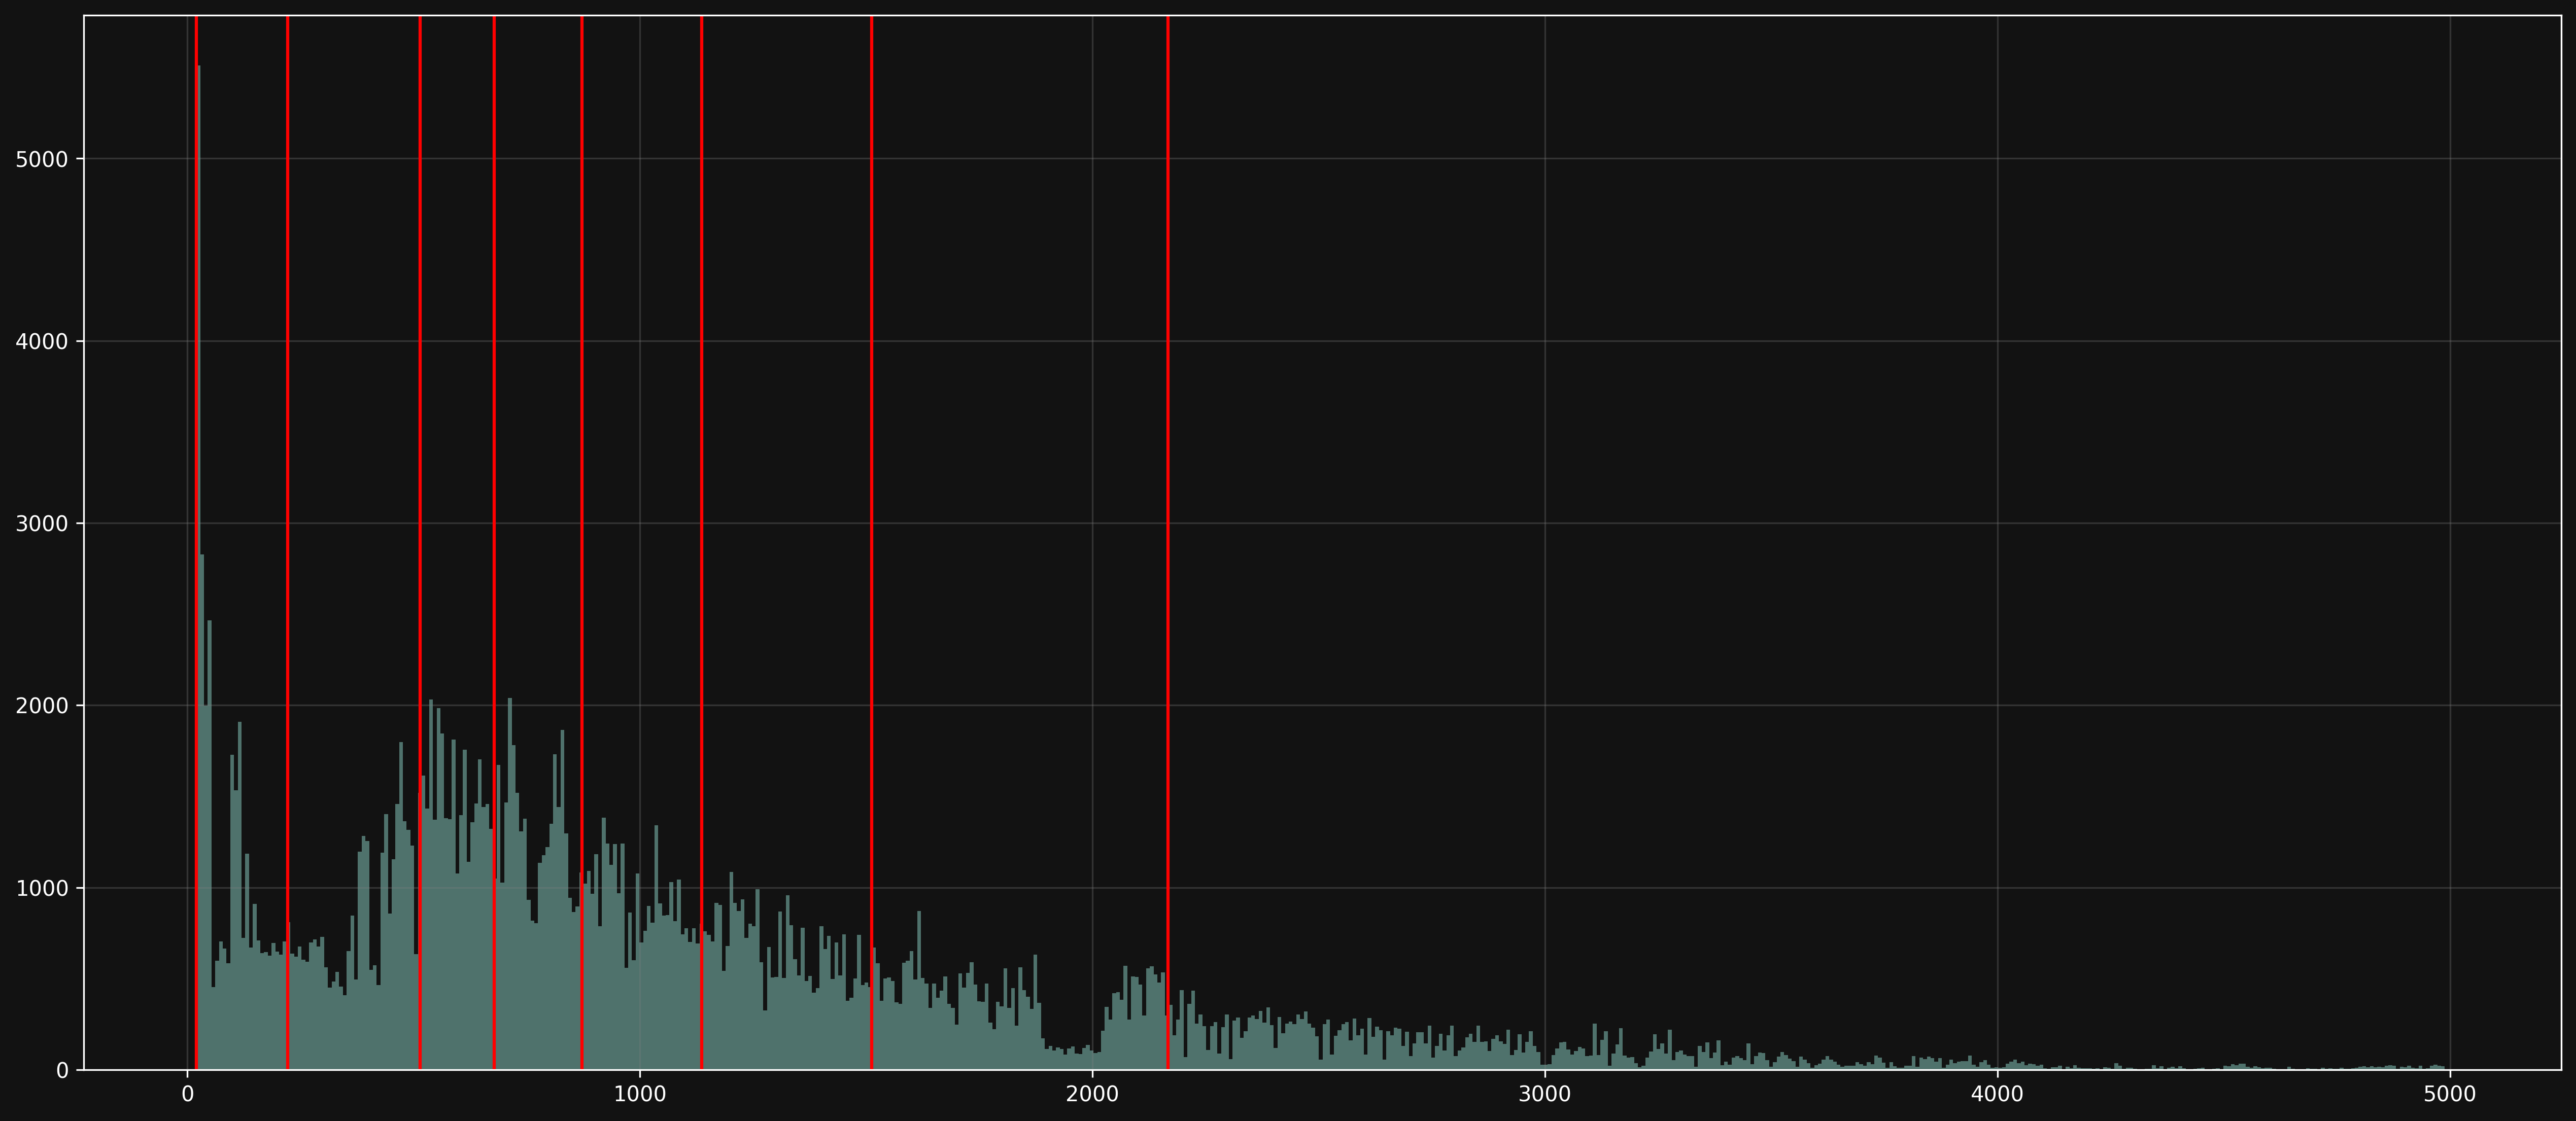

In [113]:
y_val_origin_ser = pd.Series(y_val_origin)
y_val_origin_ser.hist(bins=600, alpha=0.5)
for cut in pd.qcut(y_val_origin_ser, q=8, duplicates='raise').unique():
    plt.axvline(cut.left, color='r')

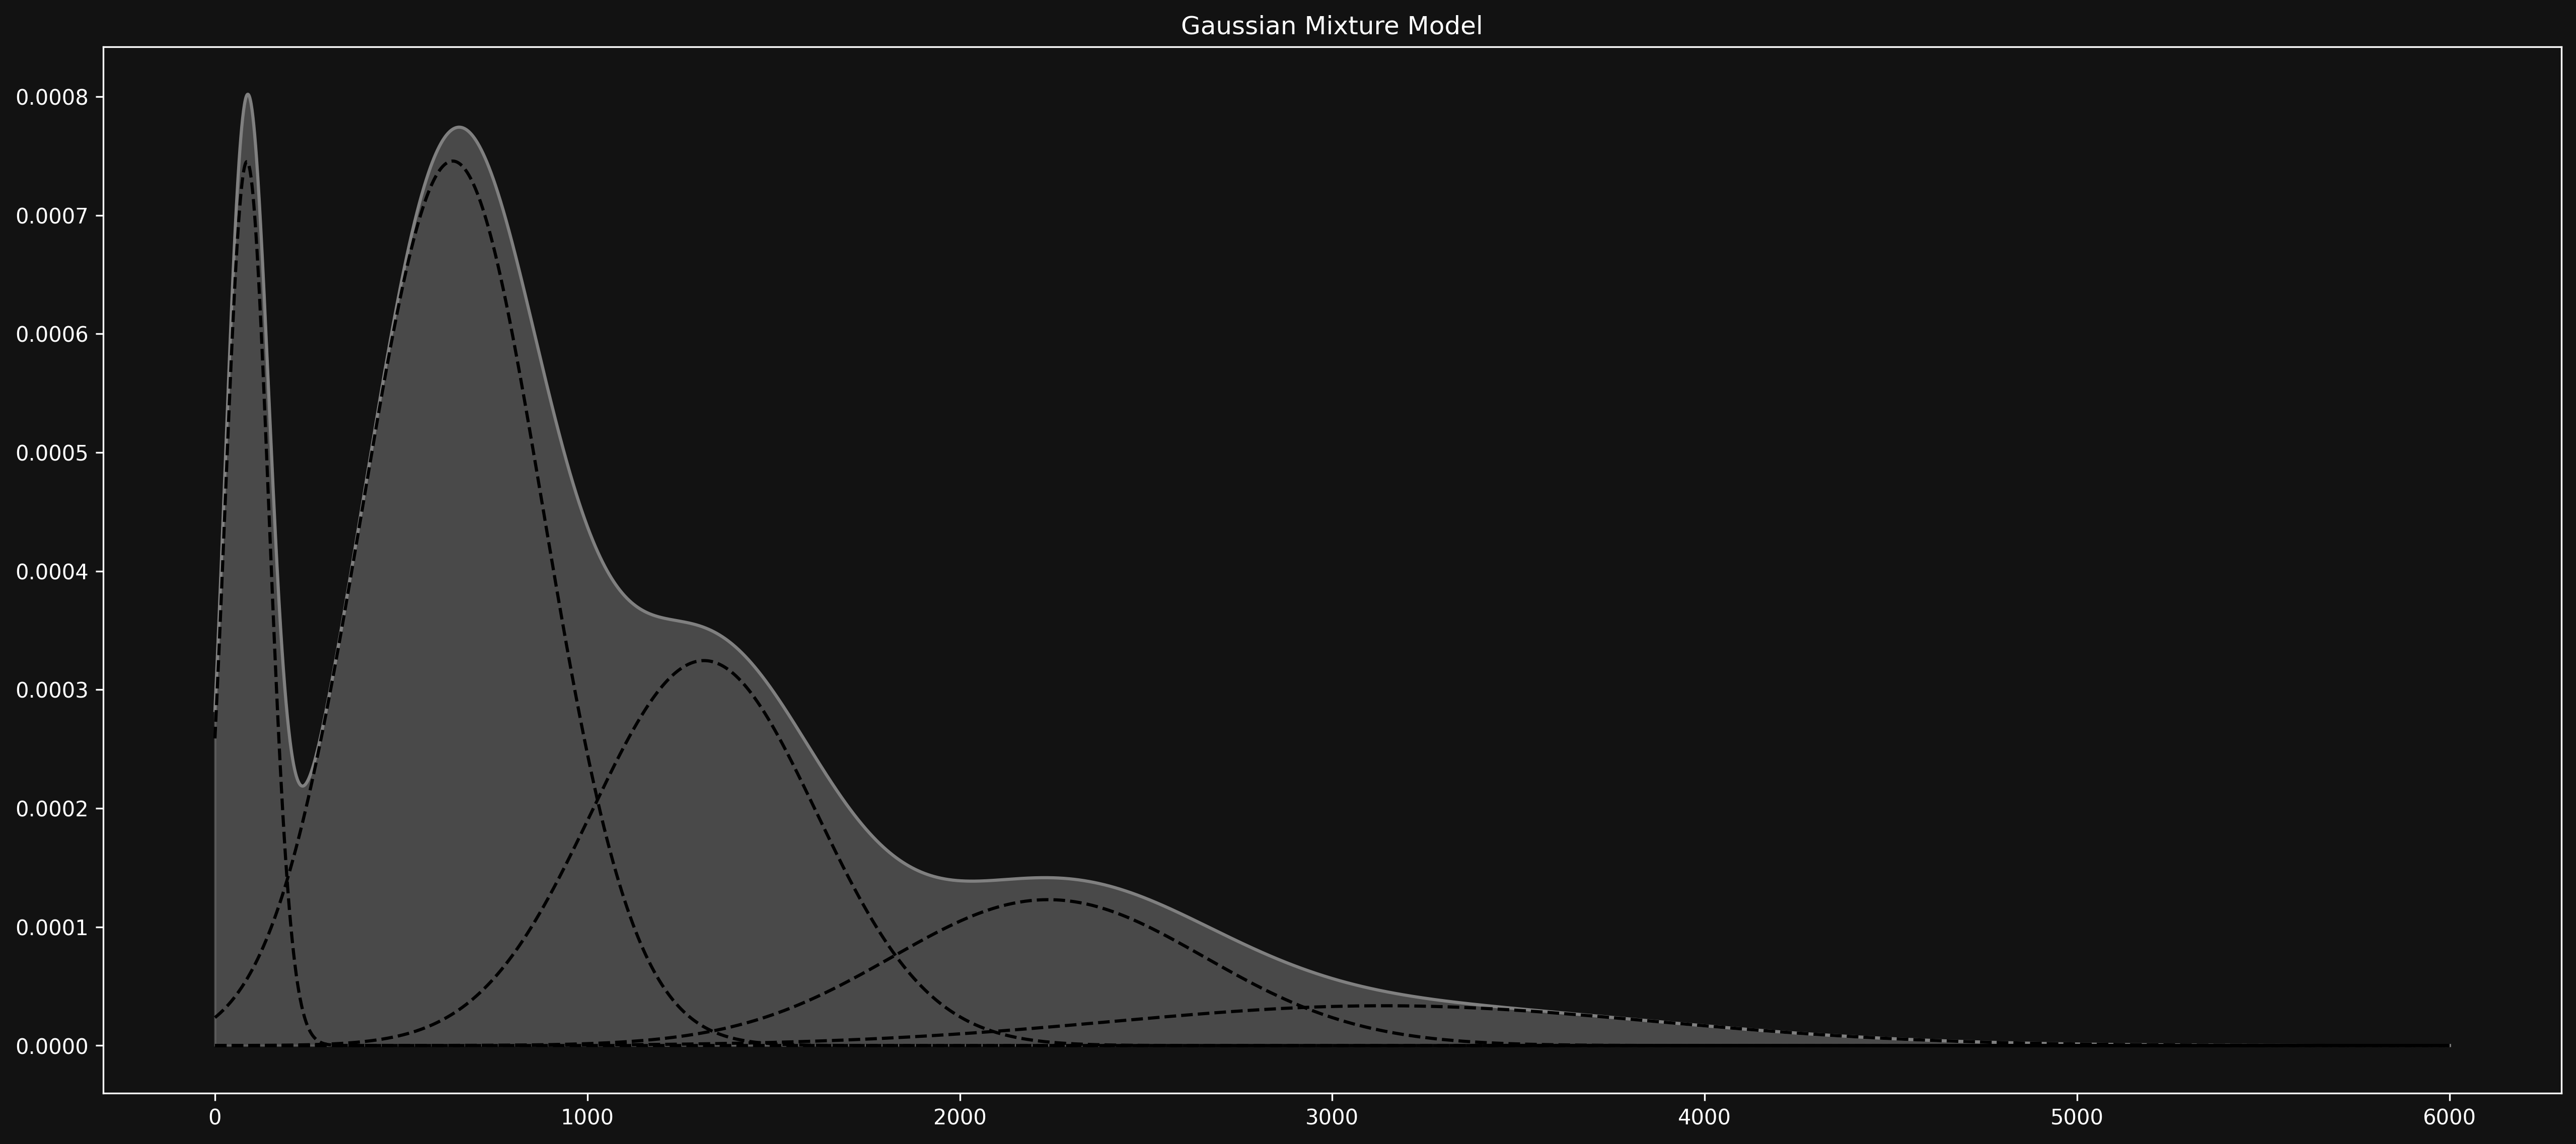

<Axes: >

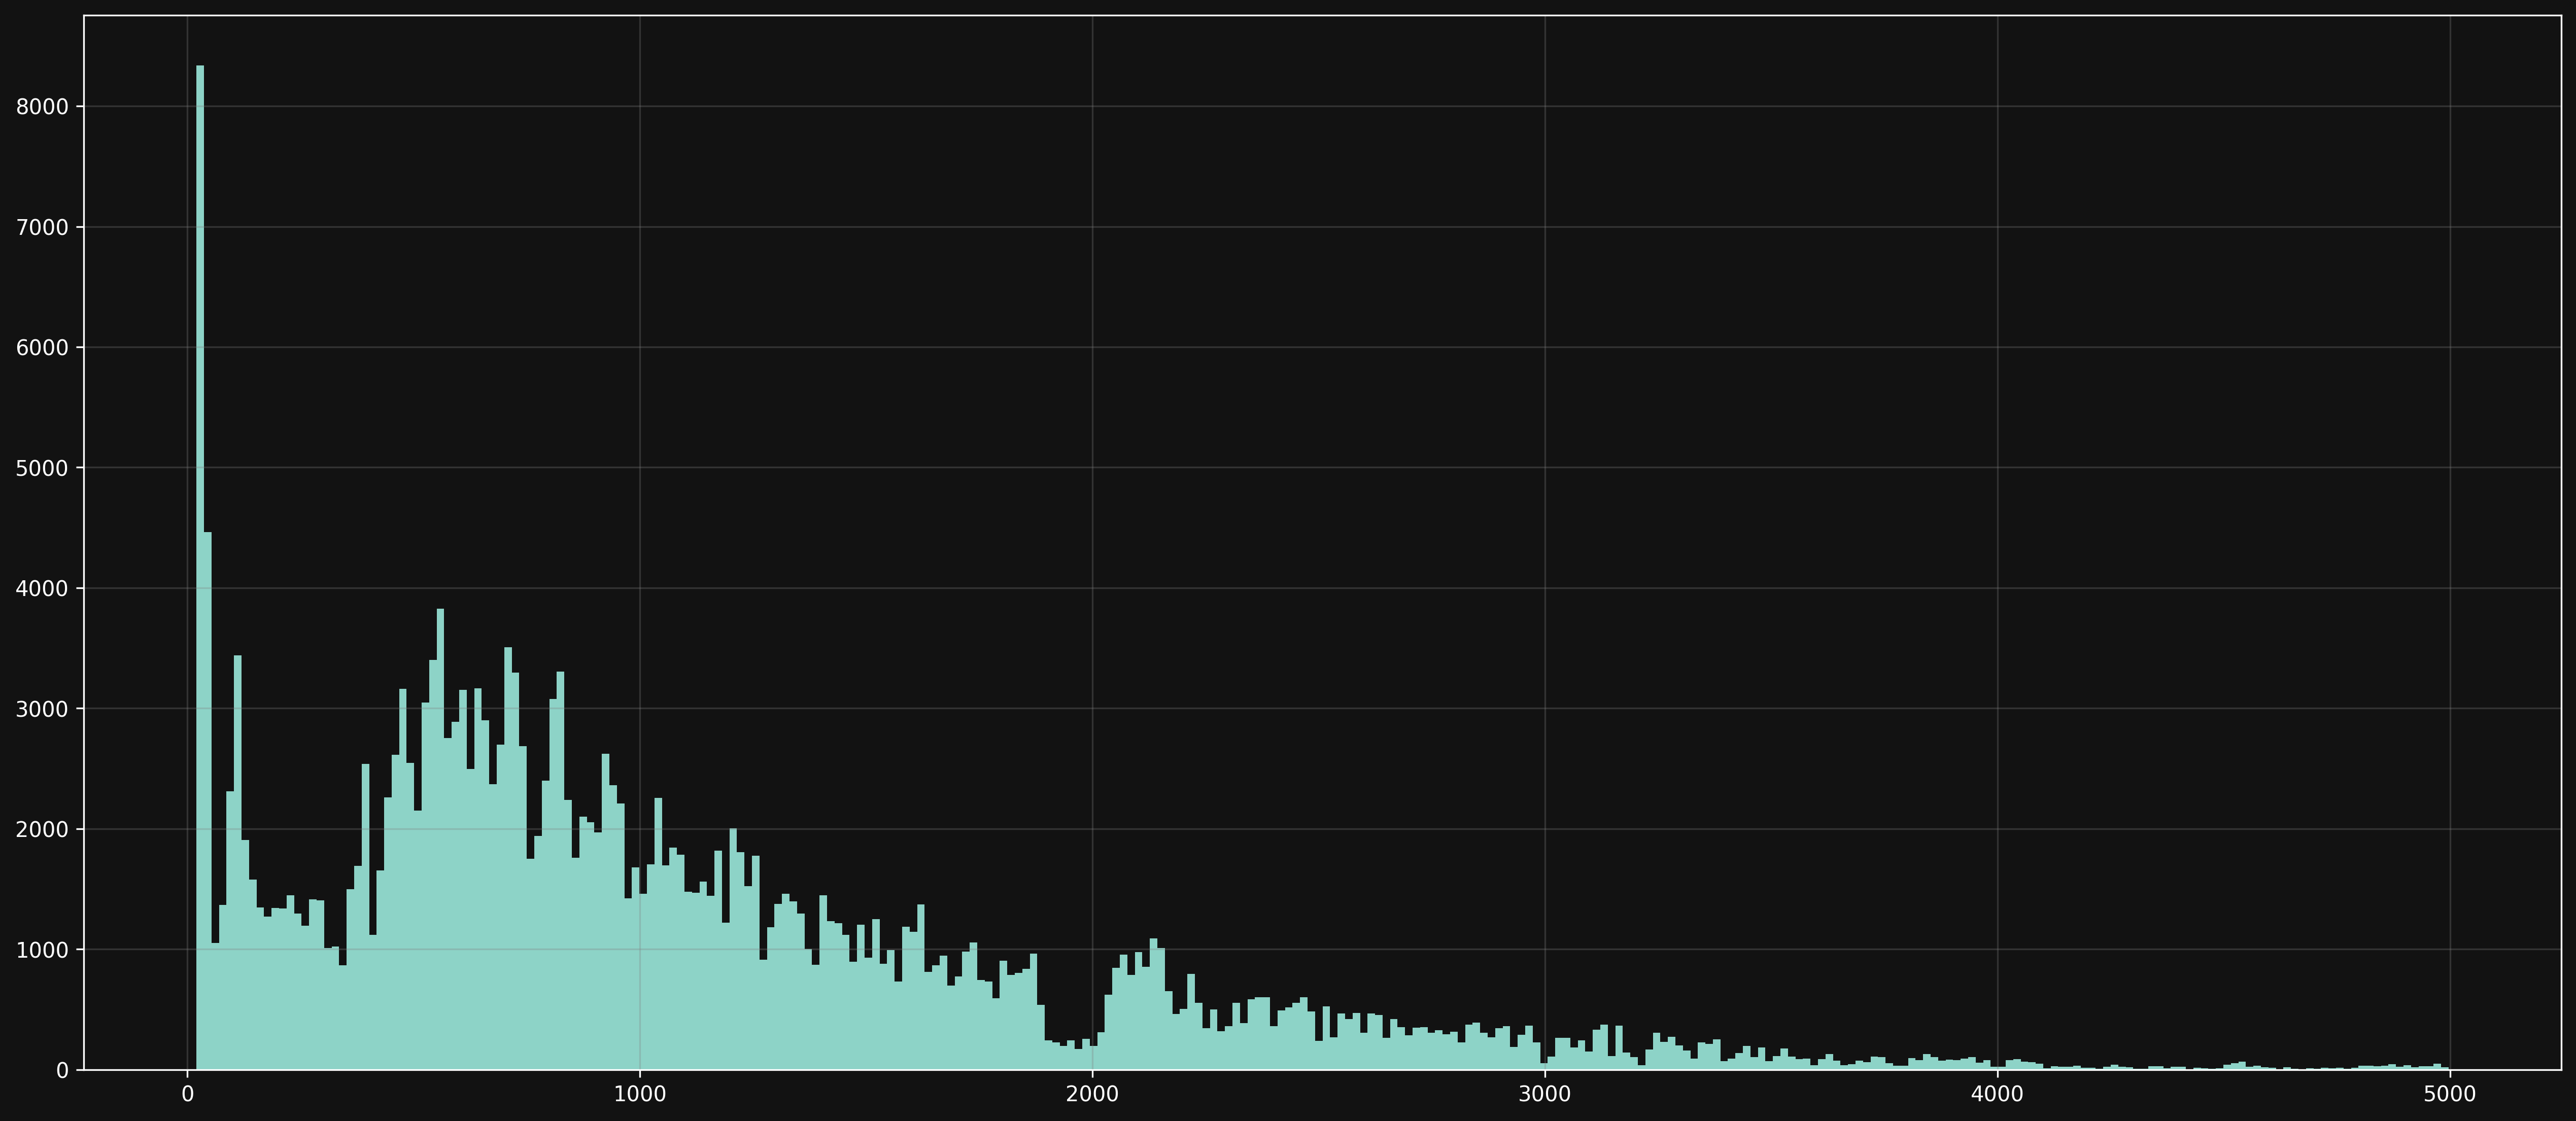

In [118]:
gmm = GaussianMixture(n_components=5, )
gmm.fit(y_val_origin_ser.values.reshape(-1, 1))

# draw three different gaussians distributions
x = np.linspace(-0, 6000,  5000)
logprob = gmm.score_samples(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = gmm.predict_proba(x.reshape(-1, 1))
pdf_individual = pdf_individual * pdf[:, np.newaxis]

plt.fill_between(x, pdf, color='gray', alpha=0.5)
plt.plot(x, pdf, color='gray')
plt.plot(x, pdf_individual, '--k')
plt.title('Gaussian Mixture Model')
plt.show()
y_val_origin_ser.hist(bins=300)

In [116]:
gmm.predict(y_val_origin_ser.values.reshape(-1, 1))

array([1, 4, 1, ..., 2, 2, 4], dtype=int64)

<Axes: >

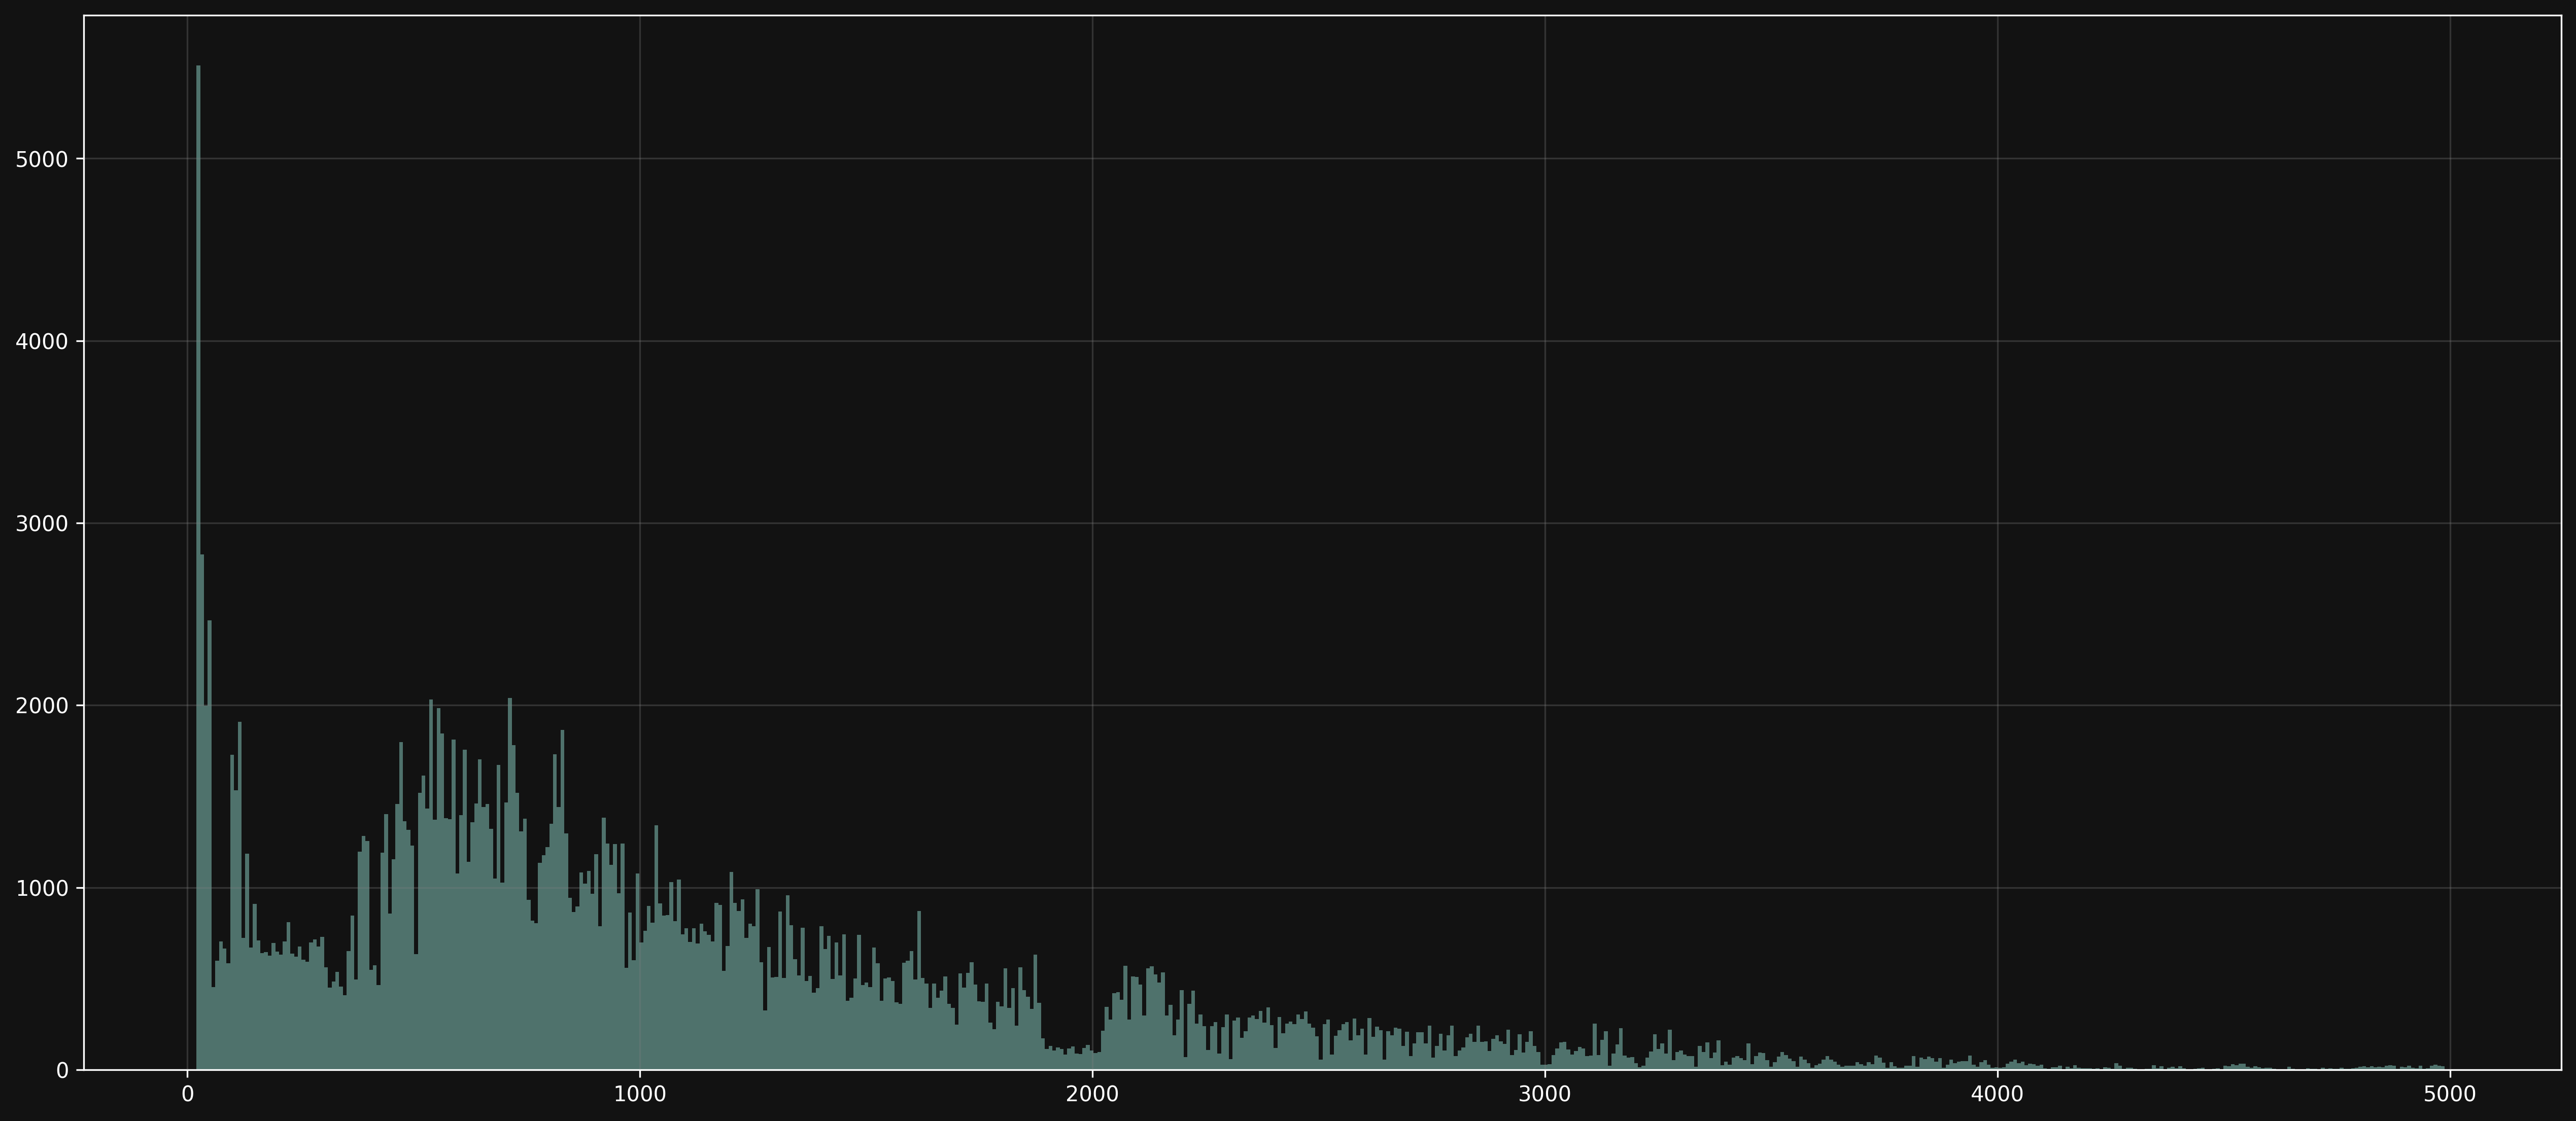

In [114]:
y_val_origin_ser.hist(bins=600, alpha=0.5)

<Axes: >

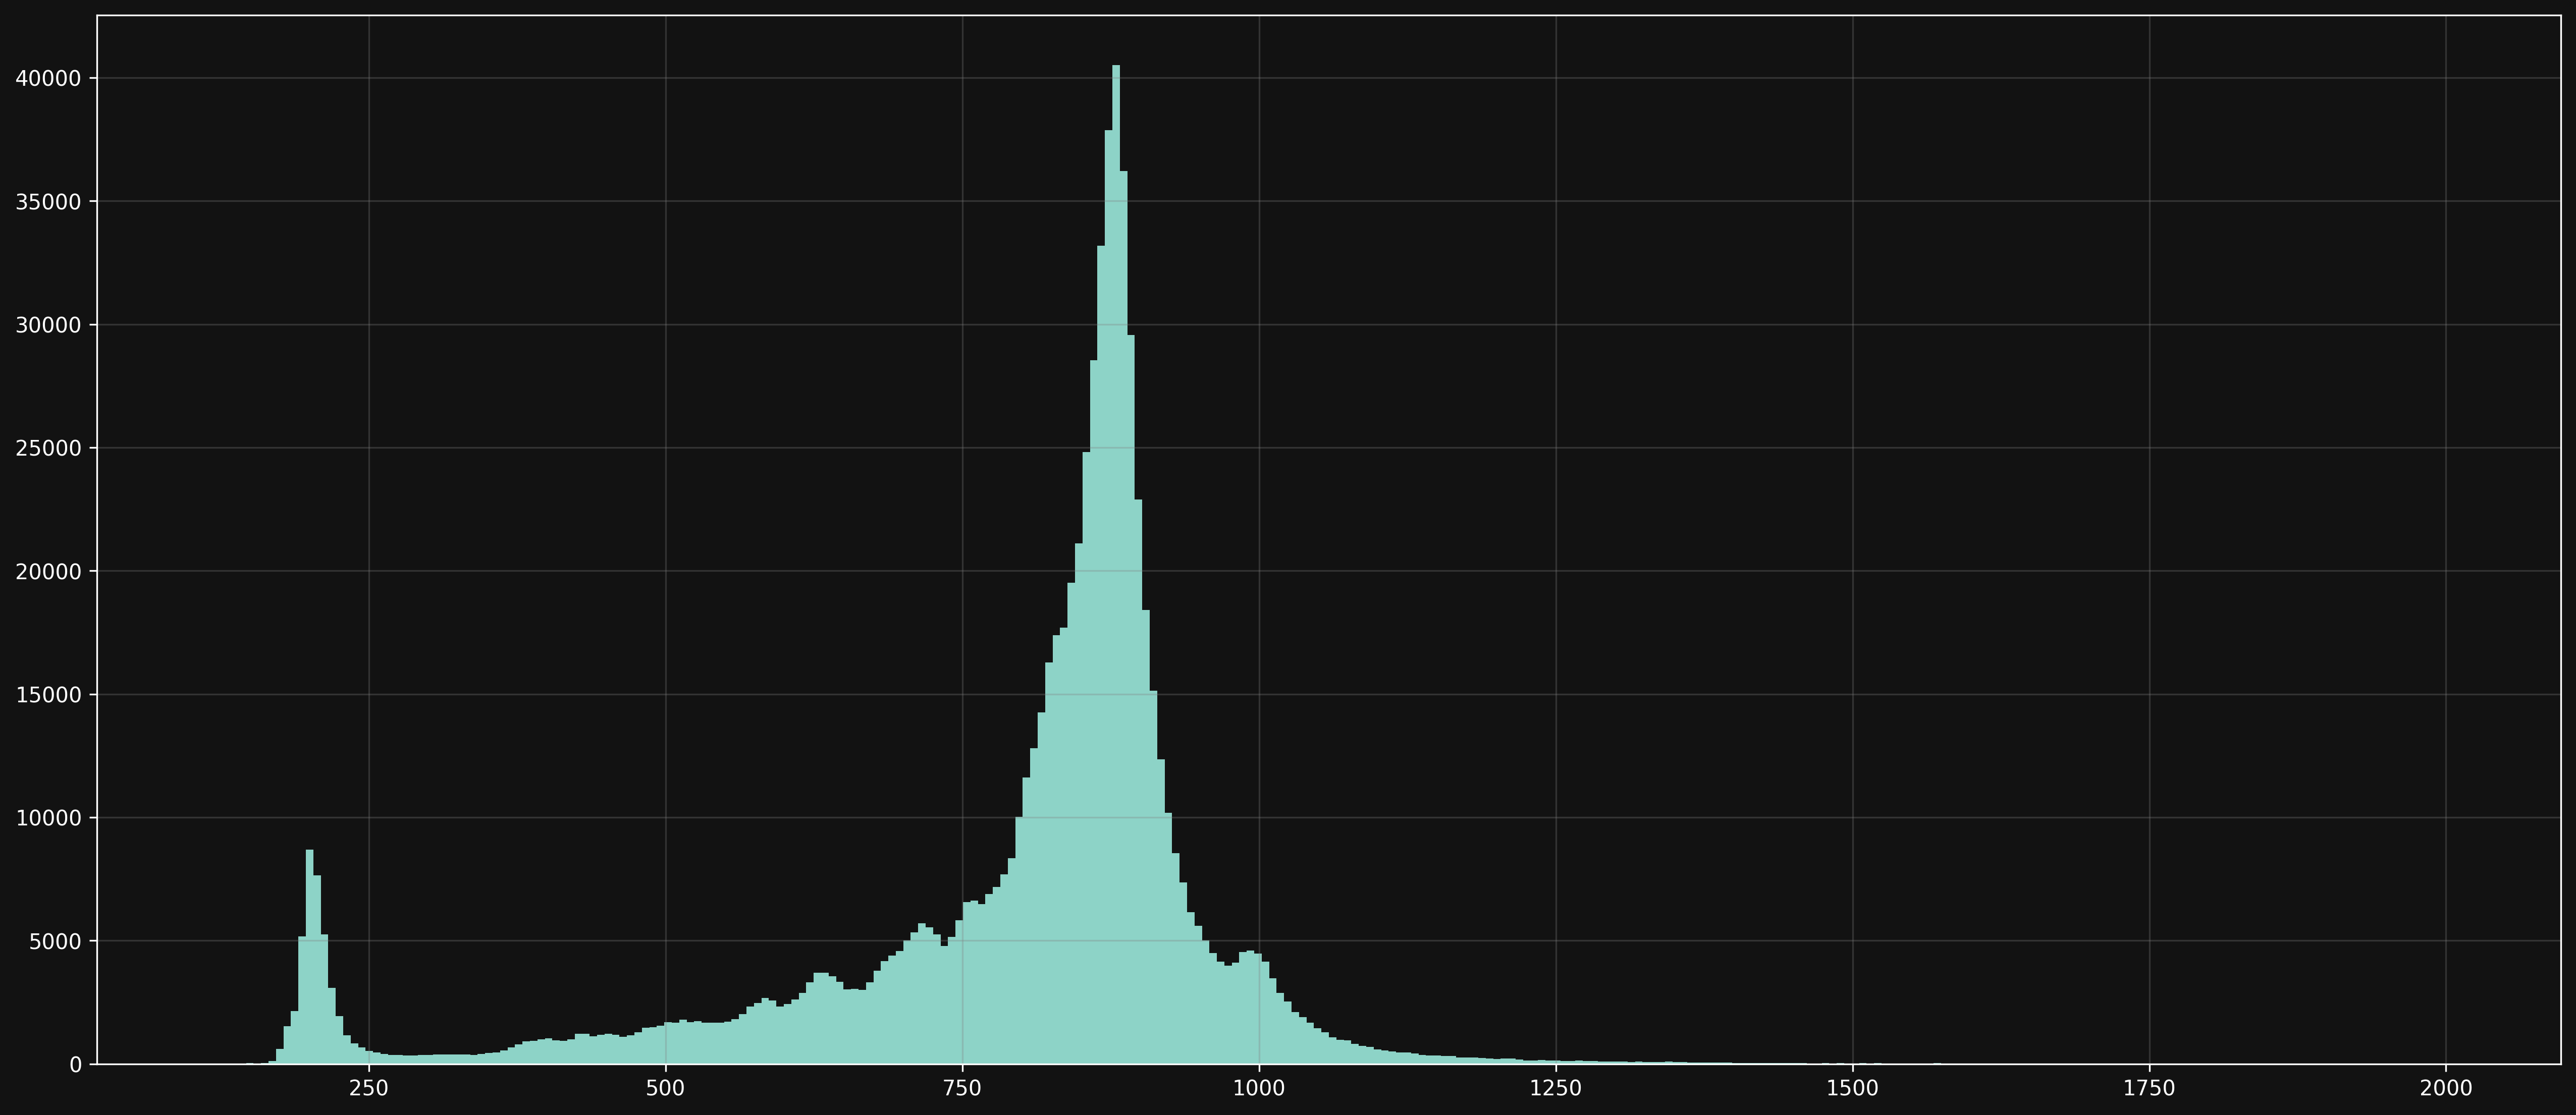

In [110]:
pd.Series(inverse_y(np.vstack(ps).T.max(axis=1)), index = test_data.index, name='Premium Amount').hist(bins=300)

In [ ]:
def mlse_with_inverse(preds, dtrain: np.ndarray):
    dtrain = inverse_y(dtrain)
    preds = inverse_y(preds)

    # preds = np.maximum(preds, epsilon)
    dtrain = np.log1p(dtrain)
    preds = np.log1p(preds)
    try:
        return 'RMLSE', np.sqrt(mean_squared_error(dtrain, preds)), False
    except:
        return 'RMLSE', 10, False

In [26]:
def lgbm_objective(trial: optuna.Trial):
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42) 
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 400, 600),
        'max_depth': trial.suggest_int('max_depth', 20, 40),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        # 'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 5),
        # "categorical_feature": categorical_columns.values,
        "seed": 42,
        'device_type': 'gpu',
        # "eval_metric": rmlse_with_inverse,
        "verbose": -1
    }

    models = []
    overall_score = 0 
    
    for i, (train_idx, val_idx) in enumerate(kf.split(X)):
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx] 
        
        model = LGBMRegressor(**params) 
        model.fit(
            X_train,
            y_train,
            eval_set=(X_val, y_val),
            eval_metric=rmlse_with_inverse,
        ) 
        
        models.append(model) 

        y_pred = model.predict(X_val)
        y_pred = inverse_y(y_pred)
        y_pred = np.maximum(0, y_pred)
        y_val = inverse_y(y_val)
        score = rmlse(y_val, y_pred)[1]
        
        overall_score += score 
        
        print(f'=== Fold {i + 1} RMSLE Score: {score:} ===') 
        
    avg_score = overall_score / kf.n_splits 
    print(f"Overall RMSLE: {avg_score}") 

    return avg_score 

In [27]:
study = optuna.create_study(direction='minimize')
study.optimize(lgbm_objective, n_trials=100, )

[I 2024-12-26 18:39:25,717] A new study created in memory with name: no-name-4622a3b8-761c-4754-b981-116b2ff17744


=== Fold 1 RMSLE Score: 1.0334373044678296 ===
=== Fold 2 RMSLE Score: 1.032322917350245 ===
=== Fold 3 RMSLE Score: 1.0339506781037344 ===
=== Fold 4 RMSLE Score: 1.0311663775956317 ===


[I 2024-12-26 18:41:33,034] Trial 0 finished with value: 1.0328446281388328 and parameters: {'num_leaves': 25, 'min_child_samples': 9, 'min_child_weight': 0.01742445783616352, 'n_estimators': 443, 'max_depth': 31, 'learning_rate': 0.010049713714955272, 'feature_fraction': 0.9838569485796165, 'bagging_fraction': 0.8706816115884023, 'lambda_l1': 0.8518384167007444, 'lambda_l2': 0.01589194514962719, 'reg_alpha': 0.013900066021231325, 'reg_lambda': 0.7506999786723523, 'subsample_freq': 2}. Best is trial 0 with value: 1.0328446281388328.


=== Fold 5 RMSLE Score: 1.0333458631767236 ===
Overall RMSLE: 1.0328446281388328


[W 2024-12-26 18:41:47,017] Trial 1 failed with parameters: {'num_leaves': 27, 'min_child_samples': 5, 'min_child_weight': 0.0012149948329592962, 'n_estimators': 568, 'max_depth': 35, 'learning_rate': 0.018762047356438882, 'feature_fraction': 0.7804745666844903, 'bagging_fraction': 0.630057432088643, 'lambda_l1': 0.5921015543315116, 'lambda_l2': 3.150467826184469, 'reg_alpha': 4.8306304997821465, 'reg_lambda': 0.013399130272965418, 'subsample_freq': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\gus47\Desktop\workspace\kaggle\regression-with-an-insurance-dataset\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\gus47\AppData\Local\Temp\ipykernel_6764\3464246506.py", line 35, in lgbm_objective
    model.fit(
  File "c:\Users\gus47\Desktop\workspace\kaggle\regression-with-an-insurance-dataset\.venv\Lib\site-packages\li

KeyboardInterrupt: 

In [28]:
study.best_params

{'n_estimators': 904,
 'learning_rate': 0.22397849703318146,
 'max_depth': 6,
 'reg_lambda': 1.0772060124044087,
 'subsample': 0.7276099887947944,
 'subsample_freq': 1,
 'min_child_samples': 12}

In [15]:
# optuna parameter search near num_leaves=31, min_child_samples=7, min_child_weight=0.003, n_estimators=500, max_depth=30, learning_rate=0.1 and wide range search for other parameters
y_val_origin = inverse_y(y_val)
def objective(trial: optuna.Trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 400, 600),
        'max_depth': trial.suggest_int('max_depth', 20, 40),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        
    }

    scores = 0
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for i, (train_idx, val_idx) in enumerate(kf.split(X)):
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]

        y_train, y_val = y[train_idx], y[val_idx] 
        model = LGBMRegressor(
            gpu_id=0,
            n_jobs=-1,
            device_type='gpu',
            verbosity=-1,
            **params,
        )
        model.fit(
            X_train,
            y_train,
            eval_set=(X_val, y_val),
            eval_metric=rmlse_with_inverse,
        ) 

        y_pred = model.predict(X_val)
        scores[val_idx] = np.maximum(0, y_pred) 
        
        score = rmlse_with_inverse(y_val, y_pred)[1]
        
        overall_score += score 
        
        print(f'=== Fold {i + 1} RMSLE Score: {score:} ===') 
        
    avg_score = overall_score / kf.n_splits 
    print(f"Overall RMSLE: {avg_score}") 
    
    return avg_score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-12-26 18:20:30,871] A new study created in memory with name: no-name-74029ec1-87db-4e89-8da4-e479ce75add5
[W 2024-12-26 18:22:06,006] Trial 0 failed with parameters: {'num_leaves': 27, 'min_child_samples': 10, 'min_child_weight': 0.006456430338839898, 'n_estimators': 595, 'max_depth': 39, 'learning_rate': 0.08506425836411159, 'feature_fraction': 0.8969224427714775, 'bagging_fraction': 0.6356935506253792, 'lambda_l1': 0.022994319446658085, 'lambda_l2': 0.005604092842773005, 'reg_alpha': 0.0072958046308591856, 'reg_lambda': 3.33350882775879, 'boosting_type': 'dart'} because of the following error: TypeError("'int' object does not support item assignment").
Traceback (most recent call last):
  File "c:\Users\gus47\Desktop\workspace\kaggle\regression-with-an-insurance-dataset\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\gus47\AppData\Local\Temp\ipykernel_6764\39869517

TypeError: 'int' object does not support item assignment

In [46]:
study.best_params, study.best_value

({'num_leaves': 40,
  'min_child_samples': 10,
  'min_child_weight': 0.06465924287223622,
  'n_estimators': 459,
  'max_depth': 30,
  'learning_rate': 0.046995524079346984,
  'feature_fraction': 0.9677961468326596,
  'bagging_fraction': 0.6627290192138932,
  'lambda_l1': 8.692580281983838,
  'lambda_l2': 3.4256066884728638,
  'reg_alpha': 0.08455745202708774,
  'reg_lambda': 0.007744807329888691,
  'boosting_type': 'gbdt'},
 1.0462689704206725)

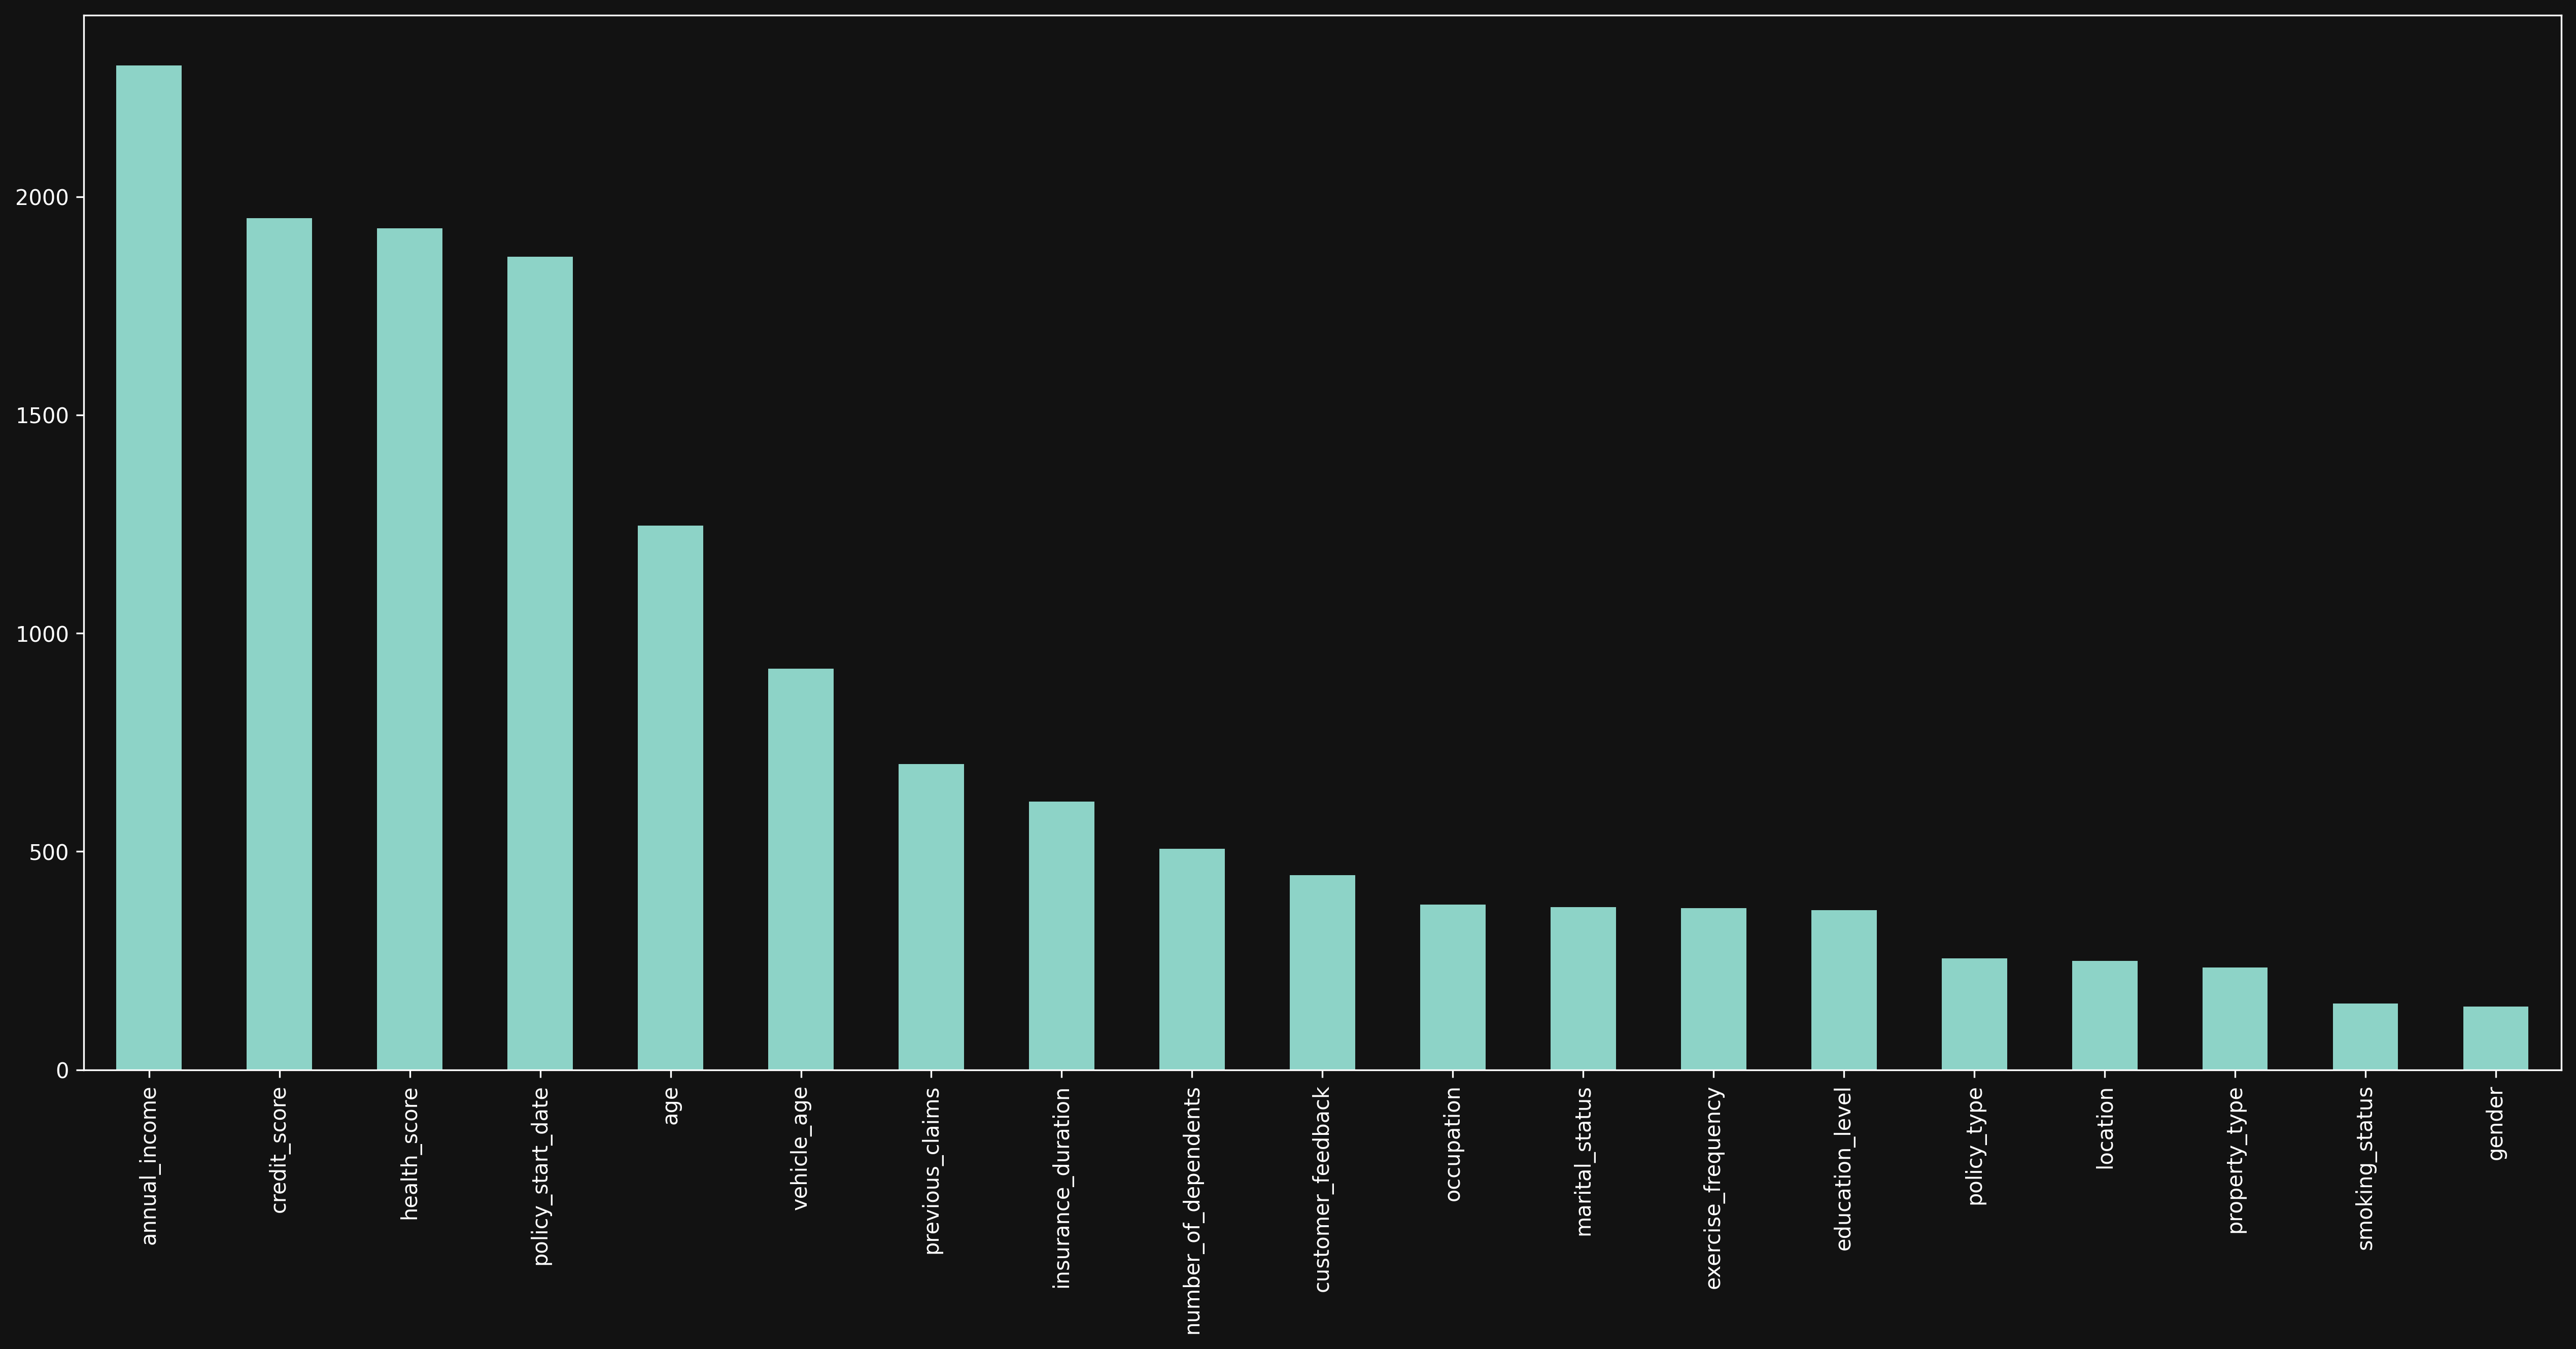

In [90]:
pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False).plot(kind='bar')
importance = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False)

In [124]:
from sklearn.ensemble import StackingRegressor
# stack catboost, xgboost, lightgbm
cbr = cat.CatBoostRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.1,
    random_state=42,
    verbose=1,
    # task_type='GPU'
)


xgbr = XGBRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    objective='reg:squarederror',
    # eval_metric='r2',
    gpu_id=0,
    # num_parallel_tree=1,
    # callbacks=[early_stop]
)

lgbr = LGBMRegressor(
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=30,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbosity=1,
)
print('fitting... catboost')
cbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)
print('fitting... xgboost')
xgbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)
print('fitting... lightgbm')
lgbr.fit(X_train, y_train, eval_set=[(X_val, y_val)])

estimators = [
    ('cbr', cbr),
    ('xgbr', xgbr),
    ('lgbm', lgbm)
]
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1, max_depth=20, verbose=50)
)
print('fitting... stack')
stack.fit(X_train, y_train)

0:	learn: 0.9917899	test: 0.9928262	best: 0.9928262 (0)	total: 390ms	remaining: 3m 14s
50:	learn: 0.9293068	test: 0.9580273	best: 0.9576874 (31)	total: 9.89s	remaining: 1m 27s
100:	learn: 0.8917020	test: 0.9599244	best: 0.9576874 (31)	total: 19.5s	remaining: 1m 17s
150:	learn: 0.8610101	test: 0.9615506	best: 0.9576874 (31)	total: 29.4s	remaining: 1m 7s
200:	learn: 0.8400563	test: 0.9627412	best: 0.9576874 (31)	total: 42.3s	remaining: 1m 2s
250:	learn: 0.8177627	test: 0.9639827	best: 0.9576874 (31)	total: 53s	remaining: 52.5s
300:	learn: 0.7942851	test: 0.9656090	best: 0.9576874 (31)	total: 1m 3s	remaining: 42.1s
350:	learn: 0.7710823	test: 0.9672136	best: 0.9576874 (31)	total: 1m 13s	remaining: 31.3s
400:	learn: 0.7500571	test: 0.9687988	best: 0.9576874 (31)	total: 1m 24s	remaining: 20.9s
450:	learn: 0.7304150	test: 0.9701036	best: 0.9576874 (31)	total: 1m 34s	remaining: 10.3s
499:	learn: 0.7115925	test: 0.9714944	best: 0.9576874 (31)	total: 1m 44s	remaining: 0us

bestTest = 0.95768744

StackingRegressor(estimators=[('cbr',
                               <catboost.core.CatBoostRegressor object at 0x17bf6e090>),
                              ('xgbr',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=0, grow_po...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                              ('lgbm',
                               LGBMRegressor(max_depth=30, min_child_samples=7,
                                             min_child_weight=0.003,
                                             n_estimators=500, n_jobs=-1,
                                             random_state=42, verbosity=1))],
                  final_estimator=RandomForestRegressor(max_depth=20,
                                                        n_estimators=500,
                                                        n_jobs=-1,
                                                        random_state=42,
                                                        verbose=50))

In [125]:
evaluate_model(stack, X_val, y_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.2s
[Para

(0.08649293657367696, 0.9144881065351448, 1.0479243516327004)

In [ ]:
test = data[data[target_column].isna()].drop(columns=[target_column, 'policy_type', 'location', 'property_type', 'smoking_status', 'gender'])
stack_pred=stack.predict(test)

In [131]:
inverse_y(stack_pred)

array([787.61949332, 831.48962063, 803.0568907 , ..., 826.88374633,
       757.40566722, 792.6202044 ])

# RMLSE 평가 방식

In [28]:
# for lgboost
from typing import Tuple

# for lgboost
def rmlse(preds, dtrain: np.ndarray):
    dtrain = np.log1p(dtrain)
    preds = np.log1p(preds)
    return 'RMLSE', np.sqrt(mean_squared_error(dtrain, preds)), False

def rmlse_with_inverse(preds, dtrain: np.ndarray):
    dtrain = inverse_y(dtrain)
    preds = inverse_y(preds)
    
    dtrain = np.log1p(dtrain)
    preds = np.log1p(preds)
    return 'RMLSE', np.sqrt(mean_squared_error(dtrain, preds)), False

# for catboost
class RMLSEMetricInv(object):
    @staticmethod
    def is_max_optimal():
        # RMLSE는 값이 작을수록 좋으므로 False 반환
        return False

    def evaluate(self, approxes, target, weight=None):
        """
        RMLSE 계산 함수.
        
        Args:
            approxes: 예측값의 리스트 (CatBoost에서 제공)
            target: 실제 타겟값
            weight: 가중치 (없을 수 있음, None 처리 필요)
        
        Returns:
            (error, weights sum)
        """
        # 예측값 가져오기
        preds = np.array(approxes[0])  # approxes는 리스트로 제공됨
        target = np.array(target)
        
        # invesre transform
        preds = inverse_y(preds)
        target = inverse_y(target)

        # 음수값 방지
        if np.any(target < 0) or np.any(preds < 0):
            raise ValueError("RMLSE cannot be calculated for negative values.")

        # 로그 변환
        preds = np.log1p(preds)
        target = np.log1p(target)

        error_sum = 0.0
        # 가중치 처리

        if weight is None:
            weight = np.ones(target.shape[0])
        
        error_sum = np.sum((weight * (preds - target) ** 2) * weight) / target.shape[0]
        weight_sum = np.sum(weight)

        return error_sum, weight_sum

    def get_final_error(self, error, weight):
        """
        최종 에러 값 반환.
        
        Args:
            error: RMLSE 값
            weight: 가중치 합계
        
        Returns:
            최종 RMLSE 값
        """
        return np.sqrt(error / (weight + 1e-38))  # RMLSE 자체를 최종 결과로 반환
    
class RMLSEMetric(object):
    @staticmethod
    def is_max_optimal():
        # RMLSE는 값이 작을수록 좋으므로 False 반환
        return False

    def evaluate(self, approxes, target, weight=None):
        """
        RMLSE 계산 함수.
        
        Args:
            approxes: 예측값의 리스트 (CatBoost에서 제공)
            target: 실제 타겟값
            weight: 가중치 (없을 수 있음, None 처리 필요)
        
        Returns:
            (error, weights sum)
        """
        if weight is None:
            weight = np.ones(target.shape[0])
        # 예측값 가져오기
        preds = np.array(approxes[0])  # approxes는 리스트로 제공됨
        target = np.array(target)


        # 음수값 방지
        if np.any(target < 0) or np.any(preds < 0):
            return 1e6, np.sum(weight)

        # 로그 변환
        preds = np.log1p(preds)
        target = np.log1p(target)

        error_sum = 0.0
        # 가중치 처리

        
        error_sum = np.sum((weight * (preds - target) ** 2) * weight) / target.shape[0]
        weight_sum = np.sum(weight)

        return error_sum, weight_sum

    def get_final_error(self, error, weight):
        """
        최종 에러 값 반환.
        
        Args:
            error: RMLSE 값
            weight: 가중치 합계
        
        Returns:
            최종 RMLSE 값
        """
        return np.sqrt(error / (weight + 1e-38))  # RMLSE 자체를 최종 결과로 반환

# for xgboost
def rmlse_objective_with_inverse(labels, preds):
    y = inverse_y(labels)
    yhat = inverse_y(preds)
    eps = 1e-6 # + 1
    y = np.maximum(labels, eps)  # Ensure preds >= 0
    yhat = np.maximum(preds, eps)  # Ensure labels >= 0
    log1p_y = np.log1p(y)
    log1p_yhat = np.log1p(yhat)

    diff = (log1p_yhat - log1p_y)

    grad = diff / (yhat + 1.0)
    hess = (1 - diff) / np.power(yhat + 1.0, 2)

    return grad, hess

def rmlse_evaluation_with_inverse(labels, preds):
    y = inverse_y(labels)
    yhat = inverse_y(preds)
    n = y.shape[0]
    eps = 1e-6
    y = np.maximum(labels, eps)  # Ensure preds >= 0
    yhat = np.maximum(preds, eps)  # Ensure labels >= 0
    log1p_y = np.log1p(y)
    log1p_yhat = np.log1p(yhat)
    rmlse = np.sqrt(np.sum((log1p_yhat - log1p_y)**2)) / n
    return rmlse


def rmlse_objective(labels, preds):
    y = labels
    yhat = preds
    eps = 1e-6 + 1
    y = np.maximum(labels, eps)  # Ensure preds >= 0
    yhat = np.maximum(preds, eps)  # Ensure labels >= 0
    log1p_y = np.log1p(y)
    log1p_yhat = np.log1p(yhat)

    diff = (log1p_yhat - log1p_y)

    grad = diff / (yhat + 1.0)
    hess = (1 - diff) / np.power(yhat + 1.0, 2)

    return grad, hess

def rmlse_evaluation(labels, preds):
    y = labels
    yhat = preds
    n = y.shape[0]
    eps = 1e-6 + 1
    y = np.maximum(labels, eps)  # Ensure preds >= 0
    yhat = np.maximum(preds, eps)  # Ensure labels >= 0
    log1p_y = np.log1p(y)
    log1p_yhat = np.log1p(yhat)
    rmlse = np.sqrt(np.sum((log1p_yhat - log1p_y)**2)) / n
    return rmlse

def gradient(labels: np.ndarray, preds: np.ndarray) -> np.ndarray:
    '''Compute the gradient squared log error.'''
    return (np.log1p(preds) - np.log1p(labels)) / (preds + 1)

def hessian(labels: np.ndarray, preds: np.ndarray) -> np.ndarray:
    '''Compute the hessian for squared log error.'''

    return ((-np.log1p(preds) + np.log1p(labels) + 1) /
            np.power(preds + 1, 2))

def squared_log(labels: np.ndarray,
                preds: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    labels[labels < -1] = -1 + 1e-6
    grad = gradient(labels, preds)
    hess = hessian(labels, preds)
    return grad, hess

In [362]:
# early_stopping_rounds
early_stop = xgb.callback.EarlyStopping(
    rounds=10, data_name='validation_0', save_best=True,# metric_name='rmse',
)
xgbr = XGBRegressor(
    n_estimators=500,
    disable_default_eval_metric=True,
    max_depth=15,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    # objective='reg:squaredlogerror',
    # objective=squared_log,
    objective=rmlse_objective,
    eval_metric=rmlse_evaluation,
    gpu_id=0,
    # num_parallel_tree=1,
    callbacks=[early_stop]
)
xgbr.fit(X_train, inverse_y(y_train), eval_set=[(X_train, inverse_y(y_train)), (X_val, inverse_y(y_val))], verbose=10)

[0]	validation_0-rmlse_evaluation:0.00613	validation_1-rmlse_evaluation:0.01225
[10]	validation_0-rmlse_evaluation:0.00547	validation_1-rmlse_evaluation:0.01093
[20]	validation_0-rmlse_evaluation:0.00467	validation_1-rmlse_evaluation:0.00935
[30]	validation_0-rmlse_evaluation:0.00391	validation_1-rmlse_evaluation:0.00782
[40]	validation_0-rmlse_evaluation:0.00319	validation_1-rmlse_evaluation:0.00639
[50]	validation_0-rmlse_evaluation:0.00254	validation_1-rmlse_evaluation:0.00508
[60]	validation_0-rmlse_evaluation:0.00198	validation_1-rmlse_evaluation:0.00396
[70]	validation_0-rmlse_evaluation:0.00155	validation_1-rmlse_evaluation:0.00310
[80]	validation_0-rmlse_evaluation:0.00129	validation_1-rmlse_evaluation:0.00258
[90]	validation_0-rmlse_evaluation:0.00117	validation_1-rmlse_evaluation:0.00234
[100]	validation_0-rmlse_evaluation:0.00113	validation_1-rmlse_evaluation:0.00226
[110]	validation_0-rmlse_evaluation:0.00111	validation_1-rmlse_evaluation:0.00223
[120]	validation_0-rmlse_ev

XGBRegressor(base_score=None, booster=None,
             callbacks=[<xgboost.callback.EarlyStopping object at 0x3001b61e0>],
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None,
             disable_default_eval_metric=True, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function rmlse_evaluation at 0x30019c220>,
             feature_types=None, gamma=None, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, ...)

In [364]:
evaluate_model_no_inverse(xgbr, X_val, inverse_y(y_val))

(-0.2166216956468372, 909163.8569230675, 1.0846654976421648)

In [323]:
evaluate_model_no_inverse(xgbr, X_val, inverse_y(y_val))

(-0.21583451785926044, 908575.6103086942, 1.0847206771631082)

In [384]:
# catboost with rmlse
cbr = cat.CatBoostRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.1,
    random_state=42,
    verbose=10,
    eval_metric=RMLSEMetricInv()
)
cbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=30)
evaluate_model(cbr, X_val, y_val)

0:	learn: 0.0011092	test: 0.0022208	best: 0.0022208 (0)	total: 331ms	remaining: 2m 45s
10:	learn: 0.0010717	test: 0.0021529	best: 0.0021529 (10)	total: 2.26s	remaining: 1m 40s
20:	learn: 0.0010618	test: 0.0021437	best: 0.0021437 (20)	total: 4.54s	remaining: 1m 43s
30:	learn: 0.0010542	test: 0.0021423	best: 0.0021423 (30)	total: 6.54s	remaining: 1m 38s
40:	learn: 0.0010465	test: 0.0021428	best: 0.0021422 (31)	total: 8.6s	remaining: 1m 36s
50:	learn: 0.0010394	test: 0.0021430	best: 0.0021422 (31)	total: 10.9s	remaining: 1m 35s
60:	learn: 0.0010313	test: 0.0021436	best: 0.0021422 (31)	total: 13s	remaining: 1m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.002142195343
bestIteration = 31

Shrink model to first 32 iterations.


(0.08381867950551047, 0.9171652355695751, 1.049457109954584)

In [29]:
lgbr = LGBMRegressor(
    num_leaves=31,
    min_child_samples=20,
    min_child_weight=0.001,
    
    n_estimators=500,
    max_depth=20,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    # verbosity=1,
)

lgbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=rmlse_with_inverse)
evaluate_model(lgbr, X_val, y_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 14
[LightGBM] [Info] Start training from score -0.000037


(0.0886444581018001, 0.9123342744224042, 1.0466895714082922)

In [ ]:
evaluate_model(lgbr, X_val, y_val)

(0.0886444581018001, 0.9123342744224042, 1.0466895714082922)

In [ ]:
# SVM
from sklearn.svm import SVR
svr = SVR(
    C=1,
    epsilon=2.25,
)
svr.fit(X_train, y_train)

In [218]:
import pickle
svr = pd.read_pickle('svr.pkl')

In [75]:
# save svr model because it takes too long to train
import pickle
with open('svr.pkl', 'wb') as f:
    pickle.dump(svr, f)

In [220]:
evaluate_model(svr, X_val[:, 1:], y_val)

(-0.41186115869286777, 1.4133773994706387, 1.3027766711381177)

# Submission

In [50]:
test = data[data[target_column].isna()].drop(columns=[target_column])

In [52]:
def make_ans(model):
    ans=inverse_y(model.predict(test.values))
    return pd.Series(ans, index = test.index).rename('Premium Amount')

In [54]:
ans = make_ans(lgbm)
ans.to_csv('submission.csv', header=True)